In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import zipfile
import IPython.display as ipd
import soundfile as sf
import glob
import parselmouth
from parselmouth.praat import call
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier ,GradientBoostingClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score ,recall_score,precision_score,f1_score
from sklearn.model_selection import KFold, cross_val_score,train_test_split
import seaborn as sns
from random import randint
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import librosa
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2FeatureExtractor
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from tqdm import tqdm

In [2]:
class SNRSegmenter(object):

    def __init__(self, sample_rate, segment_len_ms, hop_len_ms, noise_len_ms, call_snr):
        self.segment_len_samples = int(sample_rate * segment_len_ms / 1000)
        self.hop_len_samples = int(sample_rate * hop_len_ms / 1000)
        self.noise_len_samples = int(sample_rate * noise_len_ms / 1000)

        self.call_snr = call_snr

    def _get_noise_level(self, sample):
        abs_max = []

        if len(sample) > self.noise_len_samples:
            idx = 0
            while idx + self.noise_len_samples < len(sample):
                abs_max.append(np.max(np.abs(sample[idx:(idx+self.noise_len_samples)])))
                idx += self.noise_len_samples
        else:
            abs_max.append(np.max(np.abs(sample)))

        return min(abs_max)

    def __call__(self, sample):

        noise_level = self._get_noise_level(sample)

        call_segments = []
        call_snrs = []

        if len(sample) > self.segment_len_samples:
            idx = 0
            while idx + self.segment_len_samples < len(sample):
                segment = sample[idx:(idx+self.segment_len_samples)]
                seg_abs_max = np.max(np.abs(segment))
                if seg_abs_max / noise_level > self.call_snr:
                    call_segments.append(segment)
                    call_snrs.append(seg_abs_max / noise_level)

                idx += self.hop_len_samples

        return call_segments, call_snrs



In [3]:
# import os

# directory_path = "C:/Users/Vishal/Desktop/btps8e02/Dataset/MDVRKCL/SpontaneousDialogue"

# path2 = "C:/Users/Vishal/Desktop/btps8e02/Codes/SBSSS/Dataset/MDVRKCL/SpontaneousDialogue"


# root = os.listdir(directory_path)

# for entry in root:
#     # print(entry)
#     subdir_path = os.path.join(directory_path, entry) #  create the absolute path of the subdir
#     subdir_path2 = os.path.join(path2, entry)
#     # print(subdir_path)
#     if os.path.isdir(subdir_path):  # check if it is a folder
#         subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
#         for subentry in subdir_entries:
#             wav_file = os.path.join(subdir_path, subentry)  # absolute path of the subentry
#             y, sample_rate = librosa.load(wav_file)
#             # Calculate the current DC offset (mean of the audio signal)
#             dc_offset = np.mean(y)

# # Apply the DC shift
#             y_shifted = y - dc_offset

#             audio = librosa.util.normalize(y_shifted)
#             segment_len_ms = 2500
#             hop_len_ms = 1000
#             noise_len_ms = 500
#             call_snr_thresh = 15

#             segmenter = SNRSegmenter(sample_rate, segment_len_ms, hop_len_ms, noise_len_ms, call_snr_thresh)

#             calls, call_snrs = segmenter(audio)
#             h=1
#             for i in calls:
#                 # if len(subentry)>18:
#                 #     temp = subentry[:9]+ "_2_"
#                 # else:
#                 #     temp = subentry[:9]+ "_1_"
#                 file = os.path.join(subdir_path2,subentry[:9]+ "_" )
#                 # if(subentry[:4]=='ID05'):
#                 #     print(len(subentry))
#                 #     print(file)
#                 sf.write(file+str(h)+".wav",i,sample_rate)
#                 h = h+1


In [4]:
# import os

# directory_path = "C:/Users/Vishal/Desktop/btps8e02/Dataset/MDVRKCL/Readtext"

# path2 = "C:/Users/Vishal/Desktop/btps8e02/Codes/SBSSS/Dataset/MDVRKCL/Readtext"


# root = os.listdir(directory_path)

# for entry in root:
#     # print(entry)
#     subdir_path = os.path.join(directory_path, entry) #  create the absolute path of the subdir
#     subdir_path2 = os.path.join(path2, entry)
#     # print(subdir_path)
#     if os.path.isdir(subdir_path):  # check if it is a folder
#         subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
#         for subentry in subdir_entries:
#             wav_file = os.path.join(subdir_path, subentry)  # absolute path of the subentry
#             y, sample_rate = librosa.load(wav_file)
#             # Calculate the current DC offset (mean of the audio signal)
#             dc_offset = np.mean(y)

# # Apply the DC shift
#             y_shifted = y - dc_offset

#             audio = librosa.util.normalize(y_shifted)
#             segment_len_ms = 2500
#             hop_len_ms = 1000
#             noise_len_ms = 500
#             call_snr_thresh = 5

#             segmenter = SNRSegmenter(sample_rate, segment_len_ms, hop_len_ms, noise_len_ms, call_snr_thresh)

#             calls, call_snrs = segmenter(audio)
#             h=1
#             for i in calls:
#                 if len(subentry)>18:
#                     temp = subentry[:9]+ "_2_"
#                 else:
#                     temp = subentry[:9]+ "_1_"
#                 file = os.path.join(subdir_path2, temp)
#                 # if(subentry[:4]=='ID05'):
#                 #     print(len(subentry))
#                 #     print(file)
#                 sf.write(file+str(h)+".wav",i,sample_rate)
#                 h = h+1


In [5]:
def measurePitch(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)


    return meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer

In [6]:
def runPCA(df):
    #Z-score the Jitter and Shimmer measurements
    features = ['localJitter', 'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter',
                'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer']
    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the target
    #y = df.loc[:,['target']].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    #PCA
    pca = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('pca', PCA(n_components=2))  # Perform PCA
])
    # pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['JitterPCA', 'ShimmerPCA'])
    principalDf
    return principalDf

In [7]:
# processor = Wav2Vec2Processor.from_pretrained("Pongsathorn/wav2vec2_56000")
# feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("Pongsathorn/wav2vec2_56000")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# create lists to put the results
file_list = []
mean_F0_list = []
sd_F0_list = []
hnr_list = []
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list = []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list = []
disease=[]
# mfcc =[]
trans =[]


directory_path = "/home/iitg/Desktop/vishal/Dataset/MDVRKCL/Readtext"
root = os.listdir(directory_path)

for entry in root:
    # print(entry)
    subdir_path = os.path.join(directory_path, entry) #  create the absolute path of the subdir
     # print(subdir_path)
    if os.path.isdir(subdir_path):  # check if it is a folder
        subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
        for subentry in subdir_entries:
            wav_file = os.path.join(subdir_path, subentry)
            sound = parselmouth.Sound(wav_file)
            (meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(sound, 75, 500, "Hertz")
            file_list.append(subentry) # make an ID list
            mean_F0_list.append(meanF0) # make a mean F0 list
            sd_F0_list.append(stdevF0) # make a sd F0 list
            hnr_list.append(hnr)
            localJitter_list.append(localJitter)
            localabsoluteJitter_list.append(localabsoluteJitter)
            rapJitter_list.append(rapJitter)
            ppq5Jitter_list.append(ppq5Jitter)
            ddpJitter_list.append(ddpJitter)
            localShimmer_list.append(localShimmer)
            localdbShimmer_list.append(localdbShimmer)
            apq3Shimmer_list.append(apq3Shimmer)
            aqpq5Shimmer_list.append(aqpq5Shimmer)
            apq11Shimmer_list.append(apq11Shimmer)
            ddaShimmer_list.append(ddaShimmer)
            if(subentry[5] == 'p'):
                disease.append(1)
            else:
                disease.append(0)
            sample , rate = librosa.load(wav_file ,sr =16000)
            # mfc = librosa.feature.mfcc(y= sample, sr= rate,n_mfcc =13)
            # mfcc.append(mfc)
            # input_values = feature_extractor(sample, sampling_rate=rate, return_tensors="pt").input_values
            # processed_features = processor(input_values, sampling_rate=rate)
            # embeddings = np.array(processed_features.input_values).flatten()
            # Load audio file
            # audio_input, sample_rate = torchaudio.load(wav_file)
            # Preprocess audio
            inputs = processor(sample,sampling_rate=rate, return_tensors="pt", padding=True)
            # Remove extra dimensions if present
            inputs["input_values"] = inputs["input_values"]
            # Model inference
            with torch.no_grad():
                outputs = model(**inputs)
            # Extract embeddings
            last_hidden_states = outputs.last_hidden_state[0]
            last_hidden_states_np = last_hidden_states.numpy()
            embeddings = np.mean(last_hidden_states_np, axis=0)
            trans.append(embeddings)


 #adding the lists to pandas in the right order
data = pd.DataFrame(np.column_stack([file_list, mean_F0_list, sd_F0_list, hnr_list, localJitter_list, rapJitter_list, localabsoluteJitter_list, ppq5Jitter_list, ddpJitter_list, localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, apq11Shimmer_list, ddaShimmer_list,disease]),
                               columns=['voiceID', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter',  'rapJitter','localabsoluteJitter',
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer',
                                        'apq11Shimmer', 'ddaShimmer','health_status'])


In [9]:
data

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status
0,ID30_pd_2_1_21.wav,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,1
1,ID07_pd_2_1_32.wav,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,1
2,ID06_pd_3_1_39.wav,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1
3,ID02_pd_2_1_54.wav,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,1
4,ID04_pd_2_1_45.wav,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_32.wav,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,0
3945,ID09_hc_0_1_10.wav,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,0
3946,ID12_hc_0_1_77.wav,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,0
3947,ID15_hc_0_2_10.wav,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0


In [10]:
np.shape(trans)

(3949, 768)

In [11]:
# np.shape(mfcc)

In [12]:
# create lists to put the results
file_list = []
mean_F0_list = []
sd_F0_list = []
hnr_list = []
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list= []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list= []
disease=[]
# mfcc1 =[]
trans1 = []


directory_path1 = "/home/iitg/Desktop/vishal/Dataset/MDVRKCL/SpontaneousDialogue"
root1 = os.listdir(directory_path1)

for entry in root1:
    # print(entry)
    subdir_path = os.path.join(directory_path1, entry) #  create the absolute path of the subdir
     # print(subdir_path)
    if os.path.isdir(subdir_path):  # check if it is a folder
        subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
        for subentry in subdir_entries:
            wav_file = os.path.join(subdir_path, subentry)
            sound = parselmouth.Sound(wav_file)
            (meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(sound, 75, 500, "Hertz")
            file_list.append(subentry) # make an ID list
            mean_F0_list.append(meanF0) # make a mean F0 list
            sd_F0_list.append(stdevF0) # make a sd F0 list
            hnr_list.append(hnr)
            localJitter_list.append(localJitter)
            localabsoluteJitter_list.append(localabsoluteJitter)
            rapJitter_list.append(rapJitter)
            ppq5Jitter_list.append(ppq5Jitter)
            ddpJitter_list.append(ddpJitter)
            localShimmer_list.append(localShimmer)
            localdbShimmer_list.append(localdbShimmer)
            apq3Shimmer_list.append(apq3Shimmer)
            aqpq5Shimmer_list.append(aqpq5Shimmer)
            apq11Shimmer_list.append(apq11Shimmer)
            ddaShimmer_list.append(ddaShimmer)
            if(subentry[5] == 'p'):
                disease.append(1)
            else:
                disease.append(0)
            sample , rate = librosa.load(wav_file ,sr =16000)
            # mfc = librosa.feature.mfcc(y= sample, sr= rate,n_mfcc =13)
            # mfcc1.append(mfc)
            # input_values = feature_extractor(sample, sampling_rate=rate, return_tensors="pt").input_values
            # processed_features = processor(input_values, sampling_rate=rate)
            # embeddings = np.array(processed_features.input_values).flatten()
            # Load audio file
            # audio_input, sample_rate = torchaudio.load(wav_file)
            # Preprocess audio
            inputs = processor(sample,sampling_rate=rate, return_tensors="pt", padding=True)
            # Remove extra dimensions if present
            inputs["input_values"] = inputs["input_values"]
            # Model inference
            with torch.no_grad():
                outputs = model(**inputs)
            # Extract embeddings
            last_hidden_states = outputs.last_hidden_state[0]
            last_hidden_states_np = last_hidden_states.numpy()
            embeddings = np.mean(last_hidden_states_np, axis=0)
            trans1.append(embeddings)

 #adding the lists to pandas in the right order
data1 = pd.DataFrame(np.column_stack([file_list, mean_F0_list, sd_F0_list, hnr_list, localJitter_list, rapJitter_list, localabsoluteJitter_list, ppq5Jitter_list, ddpJitter_list, localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, apq11Shimmer_list, ddaShimmer_list,disease]),
                               columns=['voiceID', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter',  'rapJitter','localabsoluteJitter',
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer',
                                        'apq11Shimmer', 'ddaShimmer','health_status'])


In [13]:
data1

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status
0,ID16_pd_2_17.wav,210.40031556820227,24.646833970281577,10.668780914086982,0.03352003044785116,0.014502855112618122,0.0001604455045722061,0.01883646475164346,0.04350856533785437,0.10951037190156815,1.0097796630499434,0.04172986737459425,0.062032214197985394,0.10463100696347467,0.12518960212378274,1
1,ID07_pd_2_68.wav,143.07602378284048,68.48918776596544,12.667750469944039,0.030492633708365677,0.010739084119023906,0.0002168875598281908,0.014013646465297673,0.03221725235707172,0.13313600658512745,1.3216190053115953,0.05729554801008228,0.07991530300745277,0.33181855324373266,0.17188664403024684,1
2,ID04_pd_2_15.wav,103.478291425241,9.65345427052407,10.134480156966719,0.029708902276541525,0.012314341577080693,0.0002867409864189196,0.014439597712422777,0.03694302473124208,0.11164228375960192,1.0985461587874374,0.04043716487866125,0.06576390091233379,0.1379217408956524,0.12131149463598376,1
3,ID24_pd_2_49.wav,468.3902700852919,13.080880146084807,0.9211672469789697,0.06940297027919086,0.038509201460806476,0.0001464153662344025,0.048811371872622335,0.11552760438241944,0.2243577875322107,1.8512418559929873,0.15416540475496368,0.07524044467145126,nan,0.46249621426489107,1
4,ID04_pd_2_45.wav,117.20295778610654,57.12933490856327,8.993997649709522,0.039692322688224535,0.018400985976983274,0.00034243950989855685,0.01823057678790025,0.05520295793094982,0.11854062277838742,1.0747149952113169,0.04860622511665444,0.06234809694306142,0.06269642158080314,0.14581867534996332,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,ID10_hc_0_50.wav,174.22409456215786,63.057157118436145,8.449937624298494,0.040380949039514454,0.020993449241165085,0.00023505082850683263,0.017473283683731376,0.06298034772349526,0.12321006775623762,1.1323749220805464,0.052195113576672954,0.07861955100376891,0.10942797144051339,0.15658534073001887,0
3627,ID11_hc_0_45.wav,287.647319601689,40.93127595790085,13.834640337741922,0.017905820323927724,0.0076247745687611,6.217221086381737e-05,0.010368933750789724,0.022874323706283298,0.06288970314946671,0.6016971902459329,0.021219906110336754,0.028340827328355012,0.032631082722559955,0.06365971833101026,0
3628,ID25_hc_0_93.wav,198.86678121010507,33.20505006798829,17.540042313576492,0.015688903364853686,0.007880194852757077,7.962911856270466e-05,0.0081782783610524,0.02364058455827123,0.06378259087151646,0.7335068980170928,0.024688201413617945,0.03775356308595011,0.06641993037183633,0.07406460424085384,0
3629,ID23_hc_0_40.wav,161.00131881725247,13.012056070071292,14.365688780681134,0.00999293168817718,0.0036639972422816166,6.19876907768976e-05,0.004471065178480323,0.01099199172684485,0.03916663246874114,0.4768646024468889,0.012091052240442513,0.01721620930292137,0.03624606804285323,0.03627315672132754,0


In [14]:
null_values = data1.isnull().any()

In [15]:

# Check for null values
null_values = data.isnull().any()

In [16]:
null_values

voiceID                False
meanF0Hz               False
stdevF0Hz              False
HNR                    False
localJitter            False
rapJitter              False
localabsoluteJitter    False
ppq5Jitter             False
ddpJitter              False
localShimmer           False
localdbShimmer         False
apq3Shimmer            False
apq5Shimmer            False
apq11Shimmer           False
ddaShimmer             False
health_status          False
dtype: bool

In [17]:
pcaData1 = runPCA(data1)

In [18]:
pcaData = runPCA(data)

In [19]:
data1 = pd.concat([data1, pcaData1], axis=1)

In [20]:
data = pd.concat([data, pcaData], axis=1)

In [21]:
data1

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID16_pd_2_17.wav,210.40031556820227,24.646833970281577,10.668780914086982,0.03352003044785116,0.014502855112618122,0.0001604455045722061,0.01883646475164346,0.04350856533785437,0.10951037190156815,1.0097796630499434,0.04172986737459425,0.062032214197985394,0.10463100696347467,0.12518960212378274,1,0.438572,0.396083
1,ID07_pd_2_68.wav,143.07602378284048,68.48918776596544,12.667750469944039,0.030492633708365677,0.010739084119023906,0.0002168875598281908,0.014013646465297673,0.03221725235707172,0.13313600658512745,1.3216190053115953,0.05729554801008228,0.07991530300745277,0.33181855324373266,0.17188664403024684,1,1.821329,-1.739087
2,ID04_pd_2_15.wav,103.478291425241,9.65345427052407,10.134480156966719,0.029708902276541525,0.012314341577080693,0.0002867409864189196,0.014439597712422777,0.03694302473124208,0.11164228375960192,1.0985461587874374,0.04043716487866125,0.06576390091233379,0.1379217408956524,0.12131149463598376,1,0.525990,0.257836
3,ID24_pd_2_49.wav,468.3902700852919,13.080880146084807,0.9211672469789697,0.06940297027919086,0.038509201460806476,0.0001464153662344025,0.048811371872622335,0.11552760438241944,0.2243577875322107,1.8512418559929873,0.15416540475496368,0.07524044467145126,nan,0.46249621426489107,1,8.857732,-0.070876
4,ID04_pd_2_45.wav,117.20295778610654,57.12933490856327,8.993997649709522,0.039692322688224535,0.018400985976983274,0.00034243950989855685,0.01823057678790025,0.05520295793094982,0.11854062277838742,1.0747149952113169,0.04860622511665444,0.06234809694306142,0.06269642158080314,0.14581867534996332,1,1.444405,1.412440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,ID10_hc_0_50.wav,174.22409456215786,63.057157118436145,8.449937624298494,0.040380949039514454,0.020993449241165085,0.00023505082850683263,0.017473283683731376,0.06298034772349526,0.12321006775623762,1.1323749220805464,0.052195113576672954,0.07861955100376891,0.10942797144051339,0.15658534073001887,0,1.872502,0.710997
3627,ID11_hc_0_45.wav,287.647319601689,40.93127595790085,13.834640337741922,0.017905820323927724,0.0076247745687611,6.217221086381737e-05,0.010368933750789724,0.022874323706283298,0.06288970314946671,0.6016971902459329,0.021219906110336754,0.028340827328355012,0.032631082722559955,0.06365971833101026,0,-2.772615,0.451826
3628,ID25_hc_0_93.wav,198.86678121010507,33.20505006798829,17.540042313576492,0.015688903364853686,0.007880194852757077,7.962911856270466e-05,0.0081782783610524,0.02364058455827123,0.06378259087151646,0.7335068980170928,0.024688201413617945,0.03775356308595011,0.06641993037183633,0.07406460424085384,0,-2.418349,0.010263
3629,ID23_hc_0_40.wav,161.00131881725247,13.012056070071292,14.365688780681134,0.00999293168817718,0.0036639972422816166,6.19876907768976e-05,0.004471065178480323,0.01099199172684485,0.03916663246874114,0.4768646024468889,0.012091052240442513,0.01721620930292137,0.03624606804285323,0.03627315672132754,0,-4.086844,0.272419


In [22]:
data

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID30_pd_2_1_21.wav,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,1,-3.818259,-1.113315
1,ID07_pd_2_1_32.wav,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,1,0.089032,0.243760
2,ID06_pd_3_1_39.wav,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1,1.030741,-1.651302
3,ID02_pd_2_1_54.wav,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,1,-1.524265,-0.206816
4,ID04_pd_2_1_45.wav,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,1,9.231832,-1.410365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_32.wav,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,0,5.288916,-0.697171
3945,ID09_hc_0_1_10.wav,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,0,-1.471152,-0.765124
3946,ID12_hc_0_1_77.wav,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,0,-0.518949,-0.072998
3947,ID15_hc_0_2_10.wav,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0,0.089318,0.720074


In [23]:
data.describe()

,JitterPCA,ShimmerPCA
count,3.949000e+03,3.949000e+03
mean,5.757753e-17,6.747367e-18
std,2.865305e+00,1.194834e+00
min,-5.667275e+00,-7.959300e+00
25%,-1.908328e+00,-6.722464e-01
50%,-4.667666e-01,1.729023e-02
75%,1.263983e+00,6.830334e-01
max,2.116857e+01,8.829128e+00


In [24]:
type(data)

pandas.core.frame.DataFrame

In [25]:
data.isnull().values.sum()

0

In [26]:
#Looking at dataset¶
# data_pd = pd.read_csv("./extracted_features.csv")

data_pd = data.copy()

In [27]:
#Looking at dataset¶
# data_pd1 = pd.read_csv("./extracted_features_spontaneous.csv")
data_pd1 = data1.copy()

In [28]:
data_pd

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID30_pd_2_1_21.wav,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,1,-3.818259,-1.113315
1,ID07_pd_2_1_32.wav,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,1,0.089032,0.243760
2,ID06_pd_3_1_39.wav,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1,1.030741,-1.651302
3,ID02_pd_2_1_54.wav,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,1,-1.524265,-0.206816
4,ID04_pd_2_1_45.wav,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,1,9.231832,-1.410365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_32.wav,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,0,5.288916,-0.697171
3945,ID09_hc_0_1_10.wav,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,0,-1.471152,-0.765124
3946,ID12_hc_0_1_77.wav,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,0,-0.518949,-0.072998
3947,ID15_hc_0_2_10.wav,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0,0.089318,0.720074


In [29]:
data_pd1

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID16_pd_2_17.wav,210.40031556820227,24.646833970281577,10.668780914086982,0.03352003044785116,0.014502855112618122,0.0001604455045722061,0.01883646475164346,0.04350856533785437,0.10951037190156815,1.0097796630499434,0.04172986737459425,0.062032214197985394,0.10463100696347467,0.12518960212378274,1,0.438572,0.396083
1,ID07_pd_2_68.wav,143.07602378284048,68.48918776596544,12.667750469944039,0.030492633708365677,0.010739084119023906,0.0002168875598281908,0.014013646465297673,0.03221725235707172,0.13313600658512745,1.3216190053115953,0.05729554801008228,0.07991530300745277,0.33181855324373266,0.17188664403024684,1,1.821329,-1.739087
2,ID04_pd_2_15.wav,103.478291425241,9.65345427052407,10.134480156966719,0.029708902276541525,0.012314341577080693,0.0002867409864189196,0.014439597712422777,0.03694302473124208,0.11164228375960192,1.0985461587874374,0.04043716487866125,0.06576390091233379,0.1379217408956524,0.12131149463598376,1,0.525990,0.257836
3,ID24_pd_2_49.wav,468.3902700852919,13.080880146084807,0.9211672469789697,0.06940297027919086,0.038509201460806476,0.0001464153662344025,0.048811371872622335,0.11552760438241944,0.2243577875322107,1.8512418559929873,0.15416540475496368,0.07524044467145126,nan,0.46249621426489107,1,8.857732,-0.070876
4,ID04_pd_2_45.wav,117.20295778610654,57.12933490856327,8.993997649709522,0.039692322688224535,0.018400985976983274,0.00034243950989855685,0.01823057678790025,0.05520295793094982,0.11854062277838742,1.0747149952113169,0.04860622511665444,0.06234809694306142,0.06269642158080314,0.14581867534996332,1,1.444405,1.412440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,ID10_hc_0_50.wav,174.22409456215786,63.057157118436145,8.449937624298494,0.040380949039514454,0.020993449241165085,0.00023505082850683263,0.017473283683731376,0.06298034772349526,0.12321006775623762,1.1323749220805464,0.052195113576672954,0.07861955100376891,0.10942797144051339,0.15658534073001887,0,1.872502,0.710997
3627,ID11_hc_0_45.wav,287.647319601689,40.93127595790085,13.834640337741922,0.017905820323927724,0.0076247745687611,6.217221086381737e-05,0.010368933750789724,0.022874323706283298,0.06288970314946671,0.6016971902459329,0.021219906110336754,0.028340827328355012,0.032631082722559955,0.06365971833101026,0,-2.772615,0.451826
3628,ID25_hc_0_93.wav,198.86678121010507,33.20505006798829,17.540042313576492,0.015688903364853686,0.007880194852757077,7.962911856270466e-05,0.0081782783610524,0.02364058455827123,0.06378259087151646,0.7335068980170928,0.024688201413617945,0.03775356308595011,0.06641993037183633,0.07406460424085384,0,-2.418349,0.010263
3629,ID23_hc_0_40.wav,161.00131881725247,13.012056070071292,14.365688780681134,0.00999293168817718,0.0036639972422816166,6.19876907768976e-05,0.004471065178480323,0.01099199172684485,0.03916663246874114,0.4768646024468889,0.012091052240442513,0.01721620930292137,0.03624606804285323,0.03627315672132754,0,-4.086844,0.272419


In [30]:
data_pd1.isnull().values.sum()

0

In [31]:
data_pd.isnull().values.sum()

0

In [32]:
data_pd1 = data_pd1.dropna()
data_pd1.drop(["voiceID"],axis =1,inplace =True)

In [33]:
data_pd = data_pd.dropna()

In [34]:
data_pd.drop(["voiceID"],axis =1,inplace =True)

In [35]:
data_pd1.reset_index(drop=True, inplace=True)
data_pd1.isnull().values.sum()

0

In [36]:
data_pd1

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,210.40031556820227,24.646833970281577,10.668780914086982,0.03352003044785116,0.014502855112618122,0.0001604455045722061,0.01883646475164346,0.04350856533785437,0.10951037190156815,1.0097796630499434,0.04172986737459425,0.062032214197985394,0.10463100696347467,0.12518960212378274,1,0.438572,0.396083
1,143.07602378284048,68.48918776596544,12.667750469944039,0.030492633708365677,0.010739084119023906,0.0002168875598281908,0.014013646465297673,0.03221725235707172,0.13313600658512745,1.3216190053115953,0.05729554801008228,0.07991530300745277,0.33181855324373266,0.17188664403024684,1,1.821329,-1.739087
2,103.478291425241,9.65345427052407,10.134480156966719,0.029708902276541525,0.012314341577080693,0.0002867409864189196,0.014439597712422777,0.03694302473124208,0.11164228375960192,1.0985461587874374,0.04043716487866125,0.06576390091233379,0.1379217408956524,0.12131149463598376,1,0.525990,0.257836
3,468.3902700852919,13.080880146084807,0.9211672469789697,0.06940297027919086,0.038509201460806476,0.0001464153662344025,0.048811371872622335,0.11552760438241944,0.2243577875322107,1.8512418559929873,0.15416540475496368,0.07524044467145126,nan,0.46249621426489107,1,8.857732,-0.070876
4,117.20295778610654,57.12933490856327,8.993997649709522,0.039692322688224535,0.018400985976983274,0.00034243950989855685,0.01823057678790025,0.05520295793094982,0.11854062277838742,1.0747149952113169,0.04860622511665444,0.06234809694306142,0.06269642158080314,0.14581867534996332,1,1.444405,1.412440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,174.22409456215786,63.057157118436145,8.449937624298494,0.040380949039514454,0.020993449241165085,0.00023505082850683263,0.017473283683731376,0.06298034772349526,0.12321006775623762,1.1323749220805464,0.052195113576672954,0.07861955100376891,0.10942797144051339,0.15658534073001887,0,1.872502,0.710997
3627,287.647319601689,40.93127595790085,13.834640337741922,0.017905820323927724,0.0076247745687611,6.217221086381737e-05,0.010368933750789724,0.022874323706283298,0.06288970314946671,0.6016971902459329,0.021219906110336754,0.028340827328355012,0.032631082722559955,0.06365971833101026,0,-2.772615,0.451826
3628,198.86678121010507,33.20505006798829,17.540042313576492,0.015688903364853686,0.007880194852757077,7.962911856270466e-05,0.0081782783610524,0.02364058455827123,0.06378259087151646,0.7335068980170928,0.024688201413617945,0.03775356308595011,0.06641993037183633,0.07406460424085384,0,-2.418349,0.010263
3629,161.00131881725247,13.012056070071292,14.365688780681134,0.00999293168817718,0.0036639972422816166,6.19876907768976e-05,0.004471065178480323,0.01099199172684485,0.03916663246874114,0.4768646024468889,0.012091052240442513,0.01721620930292137,0.03624606804285323,0.03627315672132754,0,-4.086844,0.272419


In [37]:
data_pd.isnull().values.sum()

0

In [38]:
data_pd.reset_index(drop=True, inplace=True)

In [39]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,1,-3.818259,-1.113315
1,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,1,0.089032,0.243760
2,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1,1.030741,-1.651302
3,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,1,-1.524265,-0.206816
4,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,1,9.231832,-1.410365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,0,5.288916,-0.697171
3945,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,0,-1.471152,-0.765124
3946,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,0,-0.518949,-0.072998
3947,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0,0.089318,0.720074


In [40]:
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# data_pd = pd.DataFrame(imputer.fit_transform(data_pd), columns=data_pd.columns)

In [41]:
data_pd.isnull().values.sum()

0

In [42]:
label_pd1 = data_pd1["health_status"]
data_pd1.drop(["health_status"],axis = 1,inplace = True)

print("Parkinson's disease dataset:\n",data_pd1.shape[0],"Records\n",data_pd1.shape[1],"Features")

Parkinson's disease dataset:
 3631 Records
 16 Features


In [43]:
label_pd = data_pd["health_status"]
data_pd.drop(["health_status"],axis = 1,inplace = True)

print("Parkinson's disease dataset:\n",data_pd.shape[0],"Records\n",data_pd.shape[1],"Features")

Parkinson's disease dataset:
 3949 Records
 16 Features


In [44]:
type(data_pd)

pandas.core.frame.DataFrame

In [45]:
type(label_pd[0])

str

In [46]:
def split(data_pd,label_pd):
    X_tr, X_te, Y_tr, Y_te = train_test_split(data_pd, label_pd, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

In [47]:
classifiers = ['LinearSVM', 'RadialSVM',
               'Logistic',  'RandomForest',
               'AdaBoost',  'DecisionTree',
               'KNeighbors','GradientBoosting',
               'XGBoost']

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0),
          xgb.XGBClassifier(objective="reg:logistic", random_state=42)]

In [48]:
def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

In [89]:
import pandas as pd
def Evaluate(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    spec =[]
    sens = []
    prec =[]
    f_msr=[]
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i

        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        spec.append(recall_score(Y_test, predictions, pos_label=0))
        sens.append(recall_score(Y_test, predictions))
        prec.append(precision_score(Y_test, predictions))
        f_msr.append(f1_score(Y_test, predictions))
        j = j+1
    Score["Accuracy"] = acc
    Score["Specificity"] =spec
    Score["Sensitivity"] =sens
    Score["Precision"] = prec
    Score["F Measure"] =f_msr
    # Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    # Score.reset_index(drop=True, inplace=True)
    return Score

In [50]:
logmodel = xgb.XGBClassifier(objective="reg:logistic", random_state=42)

In [51]:
#To initialize a random population.
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool_)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)

    return population

#Returns the best parents along with their score.
def fitness_score(population , pd ,label_pd,tran):
    scores = []
    le = LabelEncoder()
    le.fit(label_pd)
    label = le.transform(label_pd)
    tr =0
    for chromosome in population:
        # print(chromosome)
        jh =0
        dr = []
        count =0
        for ig in chromosome:
            if ig == True:
                count = count + 1
                if jh <16:
                    # print(np.shape(mfc[ : , jh-16, : ]))
                    dr.append(np.array(pd[ : ,jh]))
                 
                else:
                  dr= np.concatenate((dr, tran), axis=1)
            # dr = np.vstack((dr, np.array(pd[ : ,jh])))
            if jh ==15:
                dr = np.transpose(dr)
                # print(np.shape(dr))
            jh =jh+1
        # dre = np.transpose(dr)
        tr = tr+1
        print(tr)


        # np.shape(dr)
        X_train,X_test, Y_train, Y_test = split(dr,label)

        logmodel.fit(X_train,Y_train)
        predictions = logmodel.predict(X_test)
        print(np.shape(dr))
        scores.append(accuracy_score(Y_test,predictions))

    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

#Selection of the best parents.
def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents*2):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

# Picks half of the first parent and half of the second parent withy crossover rate of 0.5.
def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

#Randomly flips selected bits from the crossover child.
def mutation(pop_after_cross,mutation_rate,n_feat):
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = []
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]
        pop_next_gen.append(chromo)
    return pop_next_gen

def generations(label_pd , size,n_feat,n_parents,mutation_rate,n_gen,pd ,tran):
    best_chromo= []
    best_score =0
    population_nextgen=initilization_of_population(size,n_feat)
    for i in tqdm(range(n_gen)):
        scores, pop_after_fit = fitness_score(population_nextgen , pd ,label_pd,tran)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        print(scores[:10])
        if(scores[0]>best_score):
            best_chromo = pop_after_fit[0]
            best_score = scores[0]
        # best_chromo.append(pop_after_fit[0])
        # best_score.append(scores[0])
    return best_chromo,best_score

In [52]:
int(0.18*17)

3

In [53]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,-3.818259,-1.113315
1,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,0.089032,0.243760
2,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1.030741,-1.651302
3,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,-1.524265,-0.206816
4,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,9.231832,-1.410365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,5.288916,-0.697171
3945,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,-1.471152,-0.765124
3946,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,-0.518949,-0.072998
3947,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0.089318,0.720074


In [54]:
data_pd.isnull().values.any()

False

In [55]:
label_pd.isnull().values.any()

False

In [56]:
type(data_pd)

pandas.core.frame.DataFrame

In [57]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,-3.818259,-1.113315
1,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,0.089032,0.243760
2,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1.030741,-1.651302
3,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,-1.524265,-0.206816
4,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,9.231832,-1.410365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,5.288916,-0.697171
3945,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,-1.471152,-0.765124
3946,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,-0.518949,-0.072998
3947,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0.089318,0.720074


In [58]:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# data_pd = imputer.fit_transform(data_pd)

In [59]:
def init(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool_)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

In [60]:
label_pd1

0       1
1       1
2       1
3       1
4       1
       ..
3626    0
3627    0
3628    0
3629    0
3630    0
Name: health_status, Length: 3631, dtype: object

In [61]:
data_pd1

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,210.40031556820227,24.646833970281577,10.668780914086982,0.03352003044785116,0.014502855112618122,0.0001604455045722061,0.01883646475164346,0.04350856533785437,0.10951037190156815,1.0097796630499434,0.04172986737459425,0.062032214197985394,0.10463100696347467,0.12518960212378274,0.438572,0.396083
1,143.07602378284048,68.48918776596544,12.667750469944039,0.030492633708365677,0.010739084119023906,0.0002168875598281908,0.014013646465297673,0.03221725235707172,0.13313600658512745,1.3216190053115953,0.05729554801008228,0.07991530300745277,0.33181855324373266,0.17188664403024684,1.821329,-1.739087
2,103.478291425241,9.65345427052407,10.134480156966719,0.029708902276541525,0.012314341577080693,0.0002867409864189196,0.014439597712422777,0.03694302473124208,0.11164228375960192,1.0985461587874374,0.04043716487866125,0.06576390091233379,0.1379217408956524,0.12131149463598376,0.525990,0.257836
3,468.3902700852919,13.080880146084807,0.9211672469789697,0.06940297027919086,0.038509201460806476,0.0001464153662344025,0.048811371872622335,0.11552760438241944,0.2243577875322107,1.8512418559929873,0.15416540475496368,0.07524044467145126,nan,0.46249621426489107,8.857732,-0.070876
4,117.20295778610654,57.12933490856327,8.993997649709522,0.039692322688224535,0.018400985976983274,0.00034243950989855685,0.01823057678790025,0.05520295793094982,0.11854062277838742,1.0747149952113169,0.04860622511665444,0.06234809694306142,0.06269642158080314,0.14581867534996332,1.444405,1.412440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,174.22409456215786,63.057157118436145,8.449937624298494,0.040380949039514454,0.020993449241165085,0.00023505082850683263,0.017473283683731376,0.06298034772349526,0.12321006775623762,1.1323749220805464,0.052195113576672954,0.07861955100376891,0.10942797144051339,0.15658534073001887,1.872502,0.710997
3627,287.647319601689,40.93127595790085,13.834640337741922,0.017905820323927724,0.0076247745687611,6.217221086381737e-05,0.010368933750789724,0.022874323706283298,0.06288970314946671,0.6016971902459329,0.021219906110336754,0.028340827328355012,0.032631082722559955,0.06365971833101026,-2.772615,0.451826
3628,198.86678121010507,33.20505006798829,17.540042313576492,0.015688903364853686,0.007880194852757077,7.962911856270466e-05,0.0081782783610524,0.02364058455827123,0.06378259087151646,0.7335068980170928,0.024688201413617945,0.03775356308595011,0.06641993037183633,0.07406460424085384,-2.418349,0.010263
3629,161.00131881725247,13.012056070071292,14.365688780681134,0.00999293168817718,0.0036639972422816166,6.19876907768976e-05,0.004471065178480323,0.01099199172684485,0.03916663246874114,0.4768646024468889,0.012091052240442513,0.01721620930292137,0.03624606804285323,0.03627315672132754,-4.086844,0.272419


In [62]:
pd = np.array(data_pd)

In [63]:
# chromosome = np.ones(29,dtype=np.bool_)
# chromosome[:int(0.3*29)]=False

# jh =0
# dr = []
# for ig in chromosome:
#     if ig == True:
#         if jh >15:

#             dr= np.concatenate((dr, mfc[ : , jh-16, : ]), axis=0)
#             print(np.shape(dr))
#         else:
#             dr.append(np.array(pd[ : ,jh]))
#             print(np.shape(dr))
#             #dr = np.vstack((dr, np.array(pd[ : ,jh])))


In [64]:
#Apply Genetic Algorithm for feature selection
chromo_df_pd1,score_pd1=generations(label_pd1 ,size=100,n_feat=17,n_parents=20,mutation_rate=0.19,n_gen=20, pd = np.array(data_pd1) , tran = np.array(trans1)
                         )



  0%|          | 0/20 [00:00<?, ?it/s]

1
(3631, 779)
2
(3631, 779)
3
(3631, 779)
4
(3631, 779)
5
(3631, 779)
6
(3631, 12)
7
(3631, 12)
8
(3631, 12)
9
(3631, 12)
10
(3631, 779)
11
(3631, 12)
12
(3631, 12)
13
(3631, 779)
14
(3631, 779)
15
(3631, 12)
16
(3631, 779)
17
(3631, 779)
18
(3631, 779)
19
(3631, 12)
20
(3631, 779)
21
(3631, 779)
22
(3631, 12)
23
(3631, 12)
24
(3631, 779)
25
(3631, 779)
26
(3631, 12)
27
(3631, 779)
28
(3631, 779)
29
(3631, 12)
30
(3631, 779)
31
(3631, 779)
32
(3631, 12)
33
(3631, 779)
34
(3631, 12)
35
(3631, 779)
36
(3631, 779)
37
(3631, 779)
38
(3631, 779)
39
(3631, 779)
40
(3631, 779)
41
(3631, 12)
42
(3631, 12)
43
(3631, 779)
44
(3631, 779)
45
(3631, 779)
46
(3631, 779)
47
(3631, 12)
48
(3631, 779)
49
(3631, 779)
50
(3631, 12)
51
(3631, 12)
52
(3631, 779)
53
(3631, 12)
54
(3631, 779)
55
(3631, 779)
56
(3631, 12)
57
(3631, 779)
58
(3631, 779)
59
(3631, 12)
60
(3631, 779)
61
(3631, 779)
62
(3631, 779)
63
(3631, 779)
64
(3631, 779)
65
(3631, 779)
66
(3631, 779)
67
(3631, 779)
68
(3631, 779)
69
(3631, 7

  5%|▌         | 1/20 [21:26<6:47:29, 1286.79s/it]

(3631, 779)
100
(3631, 12)
Best score in generation 1 : [0.8314977973568282]
[0.8314977973568282, 0.8270925110132159, 0.8259911894273128, 0.8259911894273128, 0.8248898678414097, 0.8248898678414097, 0.8248898678414097, 0.8248898678414097, 0.8237885462555066, 0.8237885462555066]
1
(3631, 778)
2
(3631, 780)
3
(3631, 780)
4
(3631, 9)
5
(3631, 778)
6
(3631, 778)
7
(3631, 11)
8
(3631, 776)
9
(3631, 9)
10
(3631, 780)
11
(3631, 780)
12
(3631, 776)
13
(3631, 778)
14
(3631, 778)
15
(3631, 780)
16
(3631, 778)
17
(3631, 778)
18
(3631, 778)
19
(3631, 778)
20
(3631, 11)
21
(3631, 11)
22
(3631, 782)
23
(3631, 776)
24
(3631, 778)
25
(3631, 778)
26
(3631, 9)
27
(3631, 778)
28
(3631, 9)
29
(3631, 778)
30
(3631, 778)
31
(3631, 778)
32
(3631, 778)
33
(3631, 11)
34
(3631, 778)
35
(3631, 13)
36
(3631, 776)
37
(3631, 778)
38
(3631, 11)
39
(3631, 11)
40
(3631, 780)
41
(3631, 777)
42
(3631, 778)
43
(3631, 778)
44
(3631, 781)
45
(3631, 11)
46
(3631, 780)
47
(3631, 777)
48
(3631, 9)
49
(3631, 778)
50
(3631, 8)
5

 10%|█         | 2/20 [31:44<4:27:56, 893.15s/it] 

(3631, 778)
60
(3631, 11)
Best score in generation 2 : [0.8359030837004405]
[0.8359030837004405, 0.8259911894273128, 0.8259911894273128, 0.8259911894273128, 0.8248898678414097, 0.8248898678414097, 0.8237885462555066, 0.8215859030837004, 0.8215859030837004, 0.8215859030837004]
1
(3631, 778)
2
(3631, 777)
3
(3631, 780)
4
(3631, 779)
5
(3631, 10)
6
(3631, 779)
7
(3631, 12)
8
(3631, 776)
9
(3631, 12)
10
(3631, 8)
11
(3631, 779)
12
(3631, 10)
13
(3631, 779)
14
(3631, 779)
15
(3631, 10)
16
(3631, 780)
17
(3631, 10)
18
(3631, 777)
19
(3631, 777)
20
(3631, 777)
21
(3631, 10)
22
(3631, 777)
23
(3631, 10)
24
(3631, 779)
25
(3631, 777)
26
(3631, 10)
27
(3631, 9)
28
(3631, 778)
29
(3631, 779)
30
(3631, 779)
31
(3631, 775)
32
(3631, 8)
33
(3631, 12)
34
(3631, 12)
35
(3631, 10)
36
(3631, 8)
37
(3631, 775)
38
(3631, 779)
39
(3631, 12)
40
(3631, 777)
41
(3631, 776)
42
(3631, 776)
43
(3631, 9)
44
(3631, 778)
45
(3631, 778)
46
(3631, 777)
47
(3631, 779)
48
(3631, 780)
49
(3631, 780)
50
(3631, 10)
51
(36

 15%|█▌        | 3/20 [41:37<3:34:17, 756.33s/it]

(3631, 780)
Best score in generation 3 : [0.8337004405286343]
[0.8337004405286343, 0.8303964757709251, 0.8237885462555066, 0.8237885462555066, 0.8237885462555066, 0.8237885462555066, 0.8226872246696035, 0.8215859030837004, 0.8215859030837004, 0.8215859030837004]
1
(3631, 10)
2
(3631, 9)
3
(3631, 10)
4
(3631, 7)
5
(3631, 7)
6
(3631, 780)
7
(3631, 778)
8
(3631, 11)
9
(3631, 11)
10
(3631, 10)
11
(3631, 11)
12
(3631, 6)
13
(3631, 779)
14
(3631, 779)
15
(3631, 11)
16
(3631, 9)
17
(3631, 11)
18
(3631, 776)
19
(3631, 10)
20
(3631, 777)
21
(3631, 776)
22
(3631, 774)
23
(3631, 780)
24
(3631, 780)
25
(3631, 10)
26
(3631, 778)
27
(3631, 777)
28
(3631, 778)
29
(3631, 7)
30
(3631, 9)
31
(3631, 776)
32
(3631, 780)
33
(3631, 11)
34
(3631, 776)
35
(3631, 11)
36
(3631, 9)
37
(3631, 776)
38
(3631, 7)
39
(3631, 781)
40
(3631, 10)
41
(3631, 780)
42
(3631, 7)
43
(3631, 775)
44
(3631, 777)
45
(3631, 779)
46
(3631, 9)
47
(3631, 780)
48
(3631, 9)
49
(3631, 778)
50
(3631, 781)
51
(3631, 777)
52
(3631, 777)
53


 20%|██        | 4/20 [50:14<2:56:26, 661.65s/it]

(3631, 779)
Best score in generation 4 : [0.8359030837004405]
[0.8359030837004405, 0.8248898678414097, 0.8248898678414097, 0.8226872246696035, 0.8215859030837004, 0.8215859030837004, 0.8215859030837004, 0.8193832599118943, 0.8182819383259912, 0.8182819383259912]
1
(3631, 11)
2
(3631, 12)
3
(3631, 781)
4
(3631, 775)
5
(3631, 777)
6
(3631, 777)
7
(3631, 9)
8
(3631, 7)
9
(3631, 12)
10
(3631, 6)
11
(3631, 779)
12
(3631, 3)
13
(3631, 778)
14
(3631, 9)
15
(3631, 777)
16
(3631, 778)
17
(3631, 778)
18
(3631, 775)
19
(3631, 777)
20
(3631, 776)
21
(3631, 10)
22
(3631, 7)
23
(3631, 775)
24
(3631, 779)
25
(3631, 777)
26
(3631, 12)
27
(3631, 775)
28
(3631, 10)
29
(3631, 8)
30
(3631, 9)
31
(3631, 776)
32
(3631, 8)
33
(3631, 779)
34
(3631, 10)
35
(3631, 779)
36
(3631, 9)
37
(3631, 10)
38
(3631, 8)
39
(3631, 6)
40
(3631, 10)
41
(3631, 11)
42
(3631, 779)
43
(3631, 778)
44
(3631, 778)
45
(3631, 7)
46
(3631, 776)
47
(3631, 11)
48
(3631, 780)
49
(3631, 776)
50
(3631, 11)
51
(3631, 776)
52
(3631, 779)
53
(

 25%|██▌       | 5/20 [58:13<2:28:55, 595.69s/it]

(3631, 777)
60
(3631, 8)
Best score in generation 5 : [0.829295154185022]
[0.829295154185022, 0.829295154185022, 0.8281938325991189, 0.8248898678414097, 0.8226872246696035, 0.8215859030837004, 0.8215859030837004, 0.8204845814977973, 0.8204845814977973, 0.8204845814977973]
1
(3631, 779)
2
(3631, 778)
3
(3631, 11)
4
(3631, 9)
5
(3631, 11)
6
(3631, 782)
7
(3631, 777)
8
(3631, 10)
9
(3631, 778)
10
(3631, 7)
11
(3631, 776)
12
(3631, 780)
13
(3631, 776)
14
(3631, 4)
15
(3631, 776)
16
(3631, 778)
17
(3631, 9)
18
(3631, 774)
19
(3631, 11)
20
(3631, 8)
21
(3631, 778)
22
(3631, 13)
23
(3631, 10)
24
(3631, 774)
25
(3631, 777)
26
(3631, 778)
27
(3631, 8)
28
(3631, 10)
29
(3631, 778)
30
(3631, 776)
31
(3631, 776)
32
(3631, 7)
33
(3631, 777)
34
(3631, 776)
35
(3631, 9)
36
(3631, 776)
37
(3631, 777)
38
(3631, 10)
39
(3631, 11)
40
(3631, 774)
41
(3631, 8)
42
(3631, 12)
43
(3631, 781)
44
(3631, 8)
45
(3631, 10)
46
(3631, 10)
47
(3631, 778)
48
(3631, 775)
49
(3631, 778)
50
(3631, 9)
51
(3631, 12)
52
(36

 30%|███       | 6/20 [1:01:16<1:46:19, 455.64s/it]

(3631, 778)
Best score in generation 6 : [0.8281938325991189]
[0.8281938325991189, 0.8259911894273128, 0.8248898678414097, 0.8237885462555066, 0.8215859030837004, 0.8215859030837004, 0.8182819383259912, 0.8182819383259912, 0.8182819383259912, 0.8171806167400881]
1
(3631, 10)
2
(3631, 778)
3
(3631, 9)
4
(3631, 779)
5
(3631, 10)
6
(3631, 9)
7
(3631, 777)
8
(3631, 777)
9
(3631, 9)
10
(3631, 775)
11
(3631, 778)
12
(3631, 9)
13
(3631, 8)
14
(3631, 9)
15
(3631, 778)
16
(3631, 781)
17
(3631, 774)
18
(3631, 775)
19
(3631, 9)
20
(3631, 775)
21
(3631, 7)
22
(3631, 11)
23
(3631, 8)
24
(3631, 775)
25
(3631, 777)
26
(3631, 10)
27
(3631, 12)
28
(3631, 777)
29
(3631, 777)
30
(3631, 776)
31
(3631, 9)
32
(3631, 779)
33
(3631, 8)
34
(3631, 9)
35
(3631, 6)
36
(3631, 10)
37
(3631, 8)
38
(3631, 781)
39
(3631, 776)
40
(3631, 775)
41
(3631, 12)
42
(3631, 10)
43
(3631, 10)
44
(3631, 781)
45
(3631, 777)
46
(3631, 13)
47
(3631, 6)
48
(3631, 777)
49
(3631, 774)
50
(3631, 6)
51
(3631, 7)
52
(3631, 777)
53
(3631, 

 35%|███▌      | 7/20 [1:03:26<1:15:38, 349.15s/it]

(3631, 771)
Best score in generation 7 : [0.8237885462555066]
[0.8237885462555066, 0.8204845814977973, 0.8204845814977973, 0.8204845814977973, 0.8204845814977973, 0.8193832599118943, 0.8193832599118943, 0.8182819383259912, 0.8182819383259912, 0.8182819383259912]
1
(3631, 778)
2
(3631, 779)
3
(3631, 778)
4
(3631, 11)
5
(3631, 782)
6
(3631, 10)
7
(3631, 779)
8
(3631, 778)
9
(3631, 8)
10
(3631, 10)
11
(3631, 10)
12
(3631, 778)
13
(3631, 778)
14
(3631, 10)
15
(3631, 777)
16
(3631, 778)
17
(3631, 7)
18
(3631, 776)
19
(3631, 11)
20
(3631, 8)
21
(3631, 770)
22
(3631, 7)
23
(3631, 778)
24
(3631, 774)
25
(3631, 7)
26
(3631, 774)
27
(3631, 12)
28
(3631, 778)
29
(3631, 9)
30
(3631, 8)
31
(3631, 10)
32
(3631, 777)
33
(3631, 778)
34
(3631, 8)
35
(3631, 10)
36
(3631, 11)
37
(3631, 776)
38
(3631, 4)
39
(3631, 4)
40
(3631, 778)
41
(3631, 781)
42
(3631, 776)
43
(3631, 778)
44
(3631, 10)
45
(3631, 10)
46
(3631, 13)
47
(3631, 7)
48
(3631, 780)
49
(3631, 9)
50
(3631, 10)
51
(3631, 771)
52
(3631, 779)
53
(

 40%|████      | 8/20 [1:05:44<56:22, 281.87s/it]  

(3631, 778)
Best score in generation 8 : [0.8325991189427313]
[0.8325991189427313, 0.8314977973568282, 0.8226872246696035, 0.8226872246696035, 0.8215859030837004, 0.8204845814977973, 0.8193832599118943, 0.8193832599118943, 0.8193832599118943, 0.8182819383259912]
1
(3631, 779)
2
(3631, 7)
3
(3631, 778)
4
(3631, 777)
5
(3631, 775)
6
(3631, 7)
7
(3631, 778)
8
(3631, 12)
9
(3631, 9)
10
(3631, 781)
11
(3631, 11)
12
(3631, 777)
13
(3631, 9)
14
(3631, 779)
15
(3631, 7)
16
(3631, 775)
17
(3631, 10)
18
(3631, 778)
19
(3631, 776)
20
(3631, 7)
21
(3631, 772)
22
(3631, 777)
23
(3631, 777)
24
(3631, 10)
25
(3631, 773)
26
(3631, 776)
27
(3631, 779)
28
(3631, 778)
29
(3631, 775)
30
(3631, 779)
31
(3631, 7)
32
(3631, 12)
33
(3631, 777)
34
(3631, 11)
35
(3631, 778)
36
(3631, 776)
37
(3631, 13)
38
(3631, 12)
39
(3631, 9)
40
(3631, 778)
41
(3631, 10)
42
(3631, 774)
43
(3631, 777)
44
(3631, 779)
45
(3631, 779)
46
(3631, 773)
47
(3631, 777)
48
(3631, 773)
49
(3631, 778)
50
(3631, 775)
51
(3631, 774)
52
(36

 45%|████▌     | 9/20 [1:08:37<45:24, 247.68s/it]

(3631, 777)
Best score in generation 9 : [0.829295154185022]
[0.829295154185022, 0.8259911894273128, 0.8248898678414097, 0.8193832599118943, 0.8193832599118943, 0.8193832599118943, 0.8182819383259912, 0.8171806167400881, 0.8171806167400881, 0.816079295154185]
1
(3631, 776)
2
(3631, 778)
3
(3631, 9)
4
(3631, 780)
5
(3631, 780)
6
(3631, 778)
7
(3631, 776)
8
(3631, 775)
9
(3631, 779)
10
(3631, 777)
11
(3631, 776)
12
(3631, 776)
13
(3631, 773)
14
(3631, 778)
15
(3631, 12)
16
(3631, 776)
17
(3631, 779)
18
(3631, 776)
19
(3631, 779)
20
(3631, 775)
21
(3631, 7)
22
(3631, 776)
23
(3631, 774)
24
(3631, 772)
25
(3631, 775)
26
(3631, 776)
27
(3631, 780)
28
(3631, 11)
29
(3631, 10)
30
(3631, 10)
31
(3631, 778)
32
(3631, 780)
33
(3631, 776)
34
(3631, 781)
35
(3631, 776)
36
(3631, 12)
37
(3631, 8)
38
(3631, 8)
39
(3631, 11)
40
(3631, 777)
41
(3631, 779)
42
(3631, 778)
43
(3631, 778)
44
(3631, 12)
45
(3631, 778)
46
(3631, 776)
47
(3631, 9)
48
(3631, 777)
49
(3631, 10)
50
(3631, 773)
51
(3631, 777)
52

 50%|█████     | 10/20 [1:11:46<38:15, 229.54s/it]

(3631, 777)
Best score in generation 10 : [0.829295154185022]
[0.829295154185022, 0.8248898678414097, 0.8237885462555066, 0.8215859030837004, 0.8215859030837004, 0.8215859030837004, 0.8215859030837004, 0.8204845814977973, 0.8193832599118943, 0.8193832599118943]
1
(3631, 778)
2
(3631, 777)
3
(3631, 776)
4
(3631, 777)
5
(3631, 777)
6
(3631, 778)
7
(3631, 777)
8
(3631, 775)
9
(3631, 777)
10
(3631, 777)
11
(3631, 11)
12
(3631, 777)
13
(3631, 13)
14
(3631, 13)
15
(3631, 774)
16
(3631, 778)
17
(3631, 777)
18
(3631, 777)
19
(3631, 777)
20
(3631, 11)
21
(3631, 775)
22
(3631, 13)
23
(3631, 11)
24
(3631, 10)
25
(3631, 773)
26
(3631, 778)
27
(3631, 777)
28
(3631, 778)
29
(3631, 778)
30
(3631, 778)
31
(3631, 781)
32
(3631, 11)
33
(3631, 9)
34
(3631, 774)
35
(3631, 777)
36
(3631, 777)
37
(3631, 9)
38
(3631, 775)
39
(3631, 775)
40
(3631, 10)
41
(3631, 779)
42
(3631, 778)
43
(3631, 777)
44
(3631, 778)
45
(3631, 11)
46
(3631, 779)
47
(3631, 778)
48
(3631, 8)
49
(3631, 780)
50
(3631, 9)
51
(3631, 777)


 55%|█████▌    | 11/20 [1:19:42<45:45, 305.02s/it]

(3631, 10)
Best score in generation 11 : [0.8270925110132159]
[0.8270925110132159, 0.8237885462555066, 0.8226872246696035, 0.8215859030837004, 0.8215859030837004, 0.8204845814977973, 0.8193832599118943, 0.8182819383259912, 0.8182819383259912, 0.8182819383259912]
1
(3631, 11)
2
(3631, 776)
3
(3631, 778)
4
(3631, 778)
5
(3631, 9)
6
(3631, 778)
7
(3631, 776)
8
(3631, 776)
9
(3631, 773)
10
(3631, 780)
11
(3631, 775)
12
(3631, 780)
13
(3631, 781)
14
(3631, 778)
15
(3631, 8)
16
(3631, 775)
17
(3631, 12)
18
(3631, 780)
19
(3631, 12)
20
(3631, 5)
21
(3631, 779)
22
(3631, 776)
23
(3631, 774)
24
(3631, 10)
25
(3631, 12)
26
(3631, 776)
27
(3631, 7)
28
(3631, 10)
29
(3631, 777)
30
(3631, 776)
31
(3631, 779)
32
(3631, 776)
33
(3631, 777)
34
(3631, 776)
35
(3631, 775)
36
(3631, 777)
37
(3631, 776)
38
(3631, 777)
39
(3631, 777)
40
(3631, 10)
41
(3631, 780)
42
(3631, 10)
43
(3631, 777)
44
(3631, 774)
45
(3631, 776)
46
(3631, 777)
47
(3631, 780)
48
(3631, 778)
49
(3631, 777)
50
(3631, 777)
51
(3631, 77

 60%|██████    | 12/20 [1:28:08<48:50, 366.28s/it]

(3631, 9)
Best score in generation 12 : [0.8281938325991189]
[0.8281938325991189, 0.8248898678414097, 0.8215859030837004, 0.8204845814977973, 0.8193832599118943, 0.8182819383259912, 0.8182819383259912, 0.8171806167400881, 0.816079295154185, 0.8149779735682819]
1
(3631, 778)
2
(3631, 11)
3
(3631, 779)
4
(3631, 779)
5
(3631, 776)
6
(3631, 779)
7
(3631, 777)
8
(3631, 9)
9
(3631, 9)
10
(3631, 778)
11
(3631, 775)
12
(3631, 776)
13
(3631, 8)
14
(3631, 778)
15
(3631, 778)
16
(3631, 779)
17
(3631, 778)
18
(3631, 9)
19
(3631, 10)
20
(3631, 776)
21
(3631, 776)
22
(3631, 775)
23
(3631, 9)
24
(3631, 775)
25
(3631, 779)
26
(3631, 8)
27
(3631, 9)
28
(3631, 773)
29
(3631, 780)
30
(3631, 778)
31
(3631, 8)
32
(3631, 777)
33
(3631, 775)
34
(3631, 777)
35
(3631, 781)
36
(3631, 11)
37
(3631, 777)
38
(3631, 777)
39
(3631, 775)
40
(3631, 774)
41
(3631, 10)
42
(3631, 779)
43
(3631, 10)
44
(3631, 778)
45
(3631, 776)
46
(3631, 776)
47
(3631, 777)
48
(3631, 11)
49
(3631, 10)
50
(3631, 7)
51
(3631, 773)
52
(3631

 65%|██████▌   | 13/20 [1:33:32<41:13, 353.42s/it]

(3631, 779)
Best score in generation 13 : [0.8314977973568282]
[0.8314977973568282, 0.8270925110132159, 0.8248898678414097, 0.8237885462555066, 0.8237885462555066, 0.8226872246696035, 0.8215859030837004, 0.8215859030837004, 0.8204845814977973, 0.8193832599118943]
1
(3631, 779)
2
(3631, 778)
3
(3631, 776)
4
(3631, 7)
5
(3631, 777)
6
(3631, 778)
7
(3631, 774)
8
(3631, 776)
9
(3631, 9)
10
(3631, 779)
11
(3631, 779)
12
(3631, 779)
13
(3631, 777)
14
(3631, 781)
15
(3631, 6)
16
(3631, 8)
17
(3631, 781)
18
(3631, 10)
19
(3631, 778)
20
(3631, 772)
21
(3631, 776)
22
(3631, 778)
23
(3631, 780)
24
(3631, 11)
25
(3631, 8)
26
(3631, 776)
27
(3631, 10)
28
(3631, 776)
29
(3631, 775)
30
(3631, 776)
31
(3631, 777)
32
(3631, 774)
33
(3631, 774)
34
(3631, 8)
35
(3631, 10)
36
(3631, 775)
37
(3631, 9)
38
(3631, 778)
39
(3631, 8)
40
(3631, 778)
41
(3631, 777)
42
(3631, 11)
43
(3631, 777)
44
(3631, 779)
45
(3631, 11)
46
(3631, 775)
47
(3631, 778)
48
(3631, 776)
49
(3631, 10)
50
(3631, 779)
51
(3631, 774)
52


 70%|███████   | 14/20 [1:38:25<33:30, 335.11s/it]

(3631, 782)
60
(3631, 10)
Best score in generation 14 : [0.8314977973568282]
[0.8314977973568282, 0.8303964757709251, 0.8281938325991189, 0.8270925110132159, 0.8259911894273128, 0.8226872246696035, 0.8215859030837004, 0.8215859030837004, 0.8204845814977973, 0.8193832599118943]
1
(3631, 777)
2
(3631, 777)
3
(3631, 775)
4
(3631, 779)
5
(3631, 778)
6
(3631, 776)
7
(3631, 10)
8
(3631, 9)
9
(3631, 777)
10
(3631, 781)
11
(3631, 11)
12
(3631, 7)
13
(3631, 779)
14
(3631, 6)
15
(3631, 778)
16
(3631, 776)
17
(3631, 777)
18
(3631, 781)
19
(3631, 778)
20
(3631, 11)
21
(3631, 777)
22
(3631, 776)
23
(3631, 778)
24
(3631, 776)
25
(3631, 778)
26
(3631, 777)
27
(3631, 777)
28
(3631, 778)
29
(3631, 777)
30
(3631, 6)
31
(3631, 9)
32
(3631, 9)
33
(3631, 778)
34
(3631, 775)
35
(3631, 774)
36
(3631, 777)
37
(3631, 773)
38
(3631, 11)
39
(3631, 778)
40
(3631, 8)
41
(3631, 10)
42
(3631, 774)
43
(3631, 777)
44
(3631, 776)
45
(3631, 776)
46
(3631, 7)
47
(3631, 9)
48
(3631, 775)
49
(3631, 778)
50
(3631, 778)
51
(

 75%|███████▌  | 15/20 [1:43:09<26:39, 319.83s/it]

(3631, 775)
Best score in generation 15 : [0.8270925110132159]
[0.8270925110132159, 0.8259911894273128, 0.8226872246696035, 0.8226872246696035, 0.8215859030837004, 0.8182819383259912, 0.8182819383259912, 0.8171806167400881, 0.816079295154185, 0.816079295154185]
1
(3631, 776)
2
(3631, 775)
3
(3631, 11)
4
(3631, 9)
5
(3631, 778)
6
(3631, 777)
7
(3631, 779)
8
(3631, 12)
9
(3631, 775)
10
(3631, 10)
11
(3631, 777)
12
(3631, 778)
13
(3631, 8)
14
(3631, 776)
15
(3631, 778)
16
(3631, 780)
17
(3631, 779)
18
(3631, 776)
19
(3631, 777)
20
(3631, 6)
21
(3631, 778)
22
(3631, 779)
23
(3631, 6)
24
(3631, 777)
25
(3631, 777)
26
(3631, 778)
27
(3631, 779)
28
(3631, 776)
29
(3631, 776)
30
(3631, 8)
31
(3631, 779)
32
(3631, 778)
33
(3631, 778)
34
(3631, 8)
35
(3631, 776)
36
(3631, 7)
37
(3631, 8)
38
(3631, 775)
39
(3631, 779)
40
(3631, 11)
41
(3631, 779)
42
(3631, 776)
43
(3631, 780)
44
(3631, 10)
45
(3631, 11)
46
(3631, 777)
47
(3631, 773)
48
(3631, 780)
49
(3631, 775)
50
(3631, 778)
51
(3631, 780)
52
(

 80%|████████  | 16/20 [1:46:24<18:48, 282.24s/it]

(3631, 777)
59
(3631, 7)
60
(3631, 9)
Best score in generation 16 : [0.829295154185022]
[0.829295154185022, 0.8226872246696035, 0.8215859030837004, 0.8204845814977973, 0.8204845814977973, 0.8204845814977973, 0.8204845814977973, 0.8171806167400881, 0.8138766519823789, 0.8138766519823789]
1
(3631, 774)
2
(3631, 11)
3
(3631, 774)
4
(3631, 777)
5
(3631, 780)
6
(3631, 778)
7
(3631, 777)
8
(3631, 778)
9
(3631, 779)
10
(3631, 777)
11
(3631, 774)
12
(3631, 779)
13
(3631, 779)
14
(3631, 779)
15
(3631, 778)
16
(3631, 6)
17
(3631, 778)
18
(3631, 782)
19
(3631, 775)
20
(3631, 8)
21
(3631, 8)
22
(3631, 777)
23
(3631, 781)
24
(3631, 10)
25
(3631, 7)
26
(3631, 777)
27
(3631, 777)
28
(3631, 9)
29
(3631, 777)
30
(3631, 778)
31
(3631, 775)
32
(3631, 776)
33
(3631, 776)
34
(3631, 9)
35
(3631, 776)
36
(3631, 775)
37
(3631, 10)
38
(3631, 774)
39
(3631, 11)
40
(3631, 11)
41
(3631, 10)
42
(3631, 11)
43
(3631, 9)
44
(3631, 779)
45
(3631, 777)
46
(3631, 777)
47
(3631, 9)
48
(3631, 778)
49
(3631, 779)
50
(3631,

 85%|████████▌ | 17/20 [1:49:18<12:28, 249.56s/it]

(3631, 778)
Best score in generation 17 : [0.8303964757709251]
[0.8303964757709251, 0.8270925110132159, 0.8270925110132159, 0.8259911894273128, 0.8259911894273128, 0.8248898678414097, 0.8237885462555066, 0.8215859030837004, 0.8215859030837004, 0.8204845814977973]
1
(3631, 778)
2
(3631, 779)
3
(3631, 10)
4
(3631, 776)
5
(3631, 777)
6
(3631, 778)
7
(3631, 9)
8
(3631, 773)
9
(3631, 10)
10
(3631, 10)
11
(3631, 778)
12
(3631, 777)
13
(3631, 777)
14
(3631, 9)
15
(3631, 776)
16
(3631, 777)
17
(3631, 779)
18
(3631, 7)
19
(3631, 778)
20
(3631, 778)
21
(3631, 779)
22
(3631, 9)
23
(3631, 8)
24
(3631, 776)
25
(3631, 777)
26
(3631, 777)
27
(3631, 775)
28
(3631, 774)
29
(3631, 12)
30
(3631, 9)
31
(3631, 13)
32
(3631, 778)
33
(3631, 9)
34
(3631, 11)
35
(3631, 776)
36
(3631, 777)
37
(3631, 775)
38
(3631, 6)
39
(3631, 8)
40
(3631, 12)
41
(3631, 780)
42
(3631, 777)
43
(3631, 776)
44
(3631, 774)
45
(3631, 10)
46
(3631, 778)
47
(3631, 9)
48
(3631, 777)
49
(3631, 776)
50
(3631, 779)
51
(3631, 7)
52
(3631, 

 90%|█████████ | 18/20 [1:51:50<07:20, 220.40s/it]

(3631, 11)
59
(3631, 7)
60
(3631, 7)
Best score in generation 18 : [0.8259911894273128]
[0.8259911894273128, 0.8237885462555066, 0.8237885462555066, 0.8215859030837004, 0.8182819383259912, 0.8182819383259912, 0.8182819383259912, 0.8182819383259912, 0.8182819383259912, 0.8171806167400881]
1
(3631, 776)
2
(3631, 775)
3
(3631, 10)
4
(3631, 775)
5
(3631, 779)
6
(3631, 9)
7
(3631, 9)
8
(3631, 777)
9
(3631, 779)
10
(3631, 779)
11
(3631, 775)
12
(3631, 777)
13
(3631, 775)
14
(3631, 11)
15
(3631, 776)
16
(3631, 10)
17
(3631, 11)
18
(3631, 778)
19
(3631, 8)
20
(3631, 776)
21
(3631, 777)
22
(3631, 8)
23
(3631, 9)
24
(3631, 9)
25
(3631, 778)
26
(3631, 779)
27
(3631, 6)
28
(3631, 778)
29
(3631, 10)
30
(3631, 9)
31
(3631, 9)
32
(3631, 8)
33
(3631, 778)
34
(3631, 7)
35
(3631, 779)
36
(3631, 775)
37
(3631, 8)
38
(3631, 12)
39
(3631, 776)
40
(3631, 778)
41
(3631, 778)
42
(3631, 778)
43
(3631, 8)
44
(3631, 8)
45
(3631, 11)
46
(3631, 775)
47
(3631, 777)
48
(3631, 9)
49
(3631, 775)
50
(3631, 8)
51
(3631,

 95%|█████████▌| 19/20 [1:54:05<03:14, 194.65s/it]

(3631, 776)
59
(3631, 11)
60
(3631, 6)
Best score in generation 19 : [0.8204845814977973]
[0.8204845814977973, 0.8193832599118943, 0.8182819383259912, 0.8171806167400881, 0.816079295154185, 0.816079295154185, 0.8138766519823789, 0.8138766519823789, 0.8138766519823789, 0.8138766519823789]
1
(3631, 12)
2
(3631, 776)
3
(3631, 779)
4
(3631, 777)
5
(3631, 778)
6
(3631, 8)
7
(3631, 8)
8
(3631, 776)
9
(3631, 10)
10
(3631, 780)
11
(3631, 776)
12
(3631, 9)
13
(3631, 9)
14
(3631, 6)
15
(3631, 777)
16
(3631, 775)
17
(3631, 6)
18
(3631, 10)
19
(3631, 776)
20
(3631, 8)
21
(3631, 775)
22
(3631, 775)
23
(3631, 776)
24
(3631, 780)
25
(3631, 12)
26
(3631, 776)
27
(3631, 9)
28
(3631, 7)
29
(3631, 9)
30
(3631, 12)
31
(3631, 778)
32
(3631, 8)
33
(3631, 775)
34
(3631, 778)
35
(3631, 9)
36
(3631, 10)
37
(3631, 779)
38
(3631, 777)
39
(3631, 779)
40
(3631, 8)
41
(3631, 777)
42
(3631, 775)
43
(3631, 9)
44
(3631, 775)
45
(3631, 776)
46
(3631, 776)
47
(3631, 775)
48
(3631, 777)
49
(3631, 777)
50
(3631, 775)
51
(

100%|██████████| 20/20 [1:56:41<00:00, 350.07s/it]

(3631, 778)
60
(3631, 9)
Best score in generation 20 : [0.8270925110132159]
[0.8270925110132159, 0.8204845814977973, 0.8204845814977973, 0.8193832599118943, 0.8193832599118943, 0.816079295154185, 0.8149779735682819, 0.8149779735682819, 0.8149779735682819, 0.8138766519823789]


In [65]:
data_pd.shape[1]

16

In [66]:
#Apply Genetic Algorithm for feature selection
chromo_df_pd,score_pd=generations(label_pd ,size=100,n_feat=17,n_parents=20,mutation_rate=0.19,n_gen=20, pd = np.array(data_pd) , tran = np.array(trans))

  0%|          | 0/20 [00:00<?, ?it/s]

1
(3949, 779)
2
(3949, 12)
3
(3949, 779)
4
(3949, 12)
5
(3949, 779)
6
(3949, 779)
7
(3949, 779)
8
(3949, 779)
9
(3949, 779)
10
(3949, 779)
11
(3949, 779)
12
(3949, 12)
13
(3949, 12)
14
(3949, 12)
15
(3949, 12)
16
(3949, 779)
17
(3949, 779)
18
(3949, 779)
19
(3949, 12)
20
(3949, 779)
21
(3949, 779)
22
(3949, 779)
23
(3949, 12)
24
(3949, 779)
25
(3949, 779)
26
(3949, 779)
27
(3949, 12)
28
(3949, 779)
29
(3949, 779)
30
(3949, 779)
31
(3949, 779)
32
(3949, 779)
33
(3949, 779)
34
(3949, 779)
35
(3949, 779)
36
(3949, 12)
37
(3949, 12)
38
(3949, 779)
39
(3949, 12)
40
(3949, 779)
41
(3949, 779)
42
(3949, 12)
43
(3949, 779)
44
(3949, 779)
45
(3949, 12)
46
(3949, 779)
47
(3949, 779)
48
(3949, 779)
49
(3949, 779)
50
(3949, 779)
51
(3949, 779)
52
(3949, 779)
53
(3949, 779)
54
(3949, 779)
55
(3949, 779)
56
(3949, 779)
57
(3949, 779)
58
(3949, 779)
59
(3949, 779)
60
(3949, 12)
61
(3949, 779)
62
(3949, 12)
63
(3949, 12)
64
(3949, 779)
65
(3949, 779)
66
(3949, 12)
67
(3949, 12)
68
(3949, 779)
69
(3949

  5%|▌         | 1/20 [05:41<1:48:09, 341.56s/it]

(3949, 779)
Best score in generation 1 : [0.8633603238866396]
[0.8633603238866396, 0.8623481781376519, 0.8623481781376519, 0.8603238866396761, 0.8603238866396761, 0.8603238866396761, 0.8593117408906883, 0.8582995951417004, 0.8572874493927125, 0.8572874493927125]
1
(3949, 776)
2
(3949, 776)
3
(3949, 11)
4
(3949, 778)
5
(3949, 776)
6
(3949, 776)
7
(3949, 778)
8
(3949, 780)
9
(3949, 776)
10
(3949, 776)
11
(3949, 9)
12
(3949, 778)
13
(3949, 778)
14
(3949, 780)
15
(3949, 778)
16
(3949, 776)
17
(3949, 778)
18
(3949, 778)
19
(3949, 780)
20
(3949, 780)
21
(3949, 780)
22
(3949, 778)
23
(3949, 778)
24
(3949, 11)
25
(3949, 780)
26
(3949, 778)
27
(3949, 11)
28
(3949, 778)
29
(3949, 780)
30
(3949, 782)
31
(3949, 778)
32
(3949, 778)
33
(3949, 778)
34
(3949, 778)
35
(3949, 13)
36
(3949, 778)
37
(3949, 776)
38
(3949, 9)
39
(3949, 778)
40
(3949, 11)
41
(3949, 780)
42
(3949, 776)
43
(3949, 781)
44
(3949, 777)
45
(3949, 11)
46
(3949, 9)
47
(3949, 780)
48
(3949, 778)
49
(3949, 779)
50
(3949, 778)
51
(3949

 10%|█         | 2/20 [26:28<4:22:11, 873.97s/it]

(3949, 777)
Best score in generation 2 : [0.8674089068825911]
[0.8674089068825911, 0.8623481781376519, 0.8603238866396761, 0.8603238866396761, 0.8603238866396761, 0.8593117408906883, 0.8582995951417004, 0.8562753036437247, 0.8562753036437247, 0.8552631578947368]
1
(3949, 779)
2
(3949, 777)
3
(3949, 779)
4
(3949, 779)
5
(3949, 779)
6
(3949, 775)
7
(3949, 779)
8
(3949, 775)
9
(3949, 779)
10
(3949, 777)
11
(3949, 775)
12
(3949, 10)
13
(3949, 777)
14
(3949, 10)
15
(3949, 12)
16
(3949, 10)
17
(3949, 9)
18
(3949, 777)
19
(3949, 779)
20
(3949, 11)
21
(3949, 779)
22
(3949, 777)
23
(3949, 773)
24
(3949, 778)
25
(3949, 775)
26
(3949, 777)
27
(3949, 12)
28
(3949, 779)
29
(3949, 779)
30
(3949, 779)
31
(3949, 777)
32
(3949, 777)
33
(3949, 779)
34
(3949, 12)
35
(3949, 775)
36
(3949, 779)
37
(3949, 8)
38
(3949, 775)
39
(3949, 779)
40
(3949, 776)
41
(3949, 778)
42
(3949, 778)
43
(3949, 775)
44
(3949, 780)
45
(3949, 12)
46
(3949, 777)
47
(3949, 776)
48
(3949, 781)
49
(3949, 13)
50
(3949, 780)
51
(3949,

 15%|█▌        | 3/20 [1:02:30<6:54:21, 1462.46s/it]

(3949, 8)
Best score in generation 3 : [0.8643724696356275]
[0.8643724696356275, 0.861336032388664, 0.8603238866396761, 0.8593117408906883, 0.8582995951417004, 0.8572874493927125, 0.8572874493927125, 0.8562753036437247, 0.8562753036437247, 0.8562753036437247]
1
(3949, 777)
2
(3949, 776)
3
(3949, 776)
4
(3949, 774)
5
(3949, 10)
6
(3949, 8)
7
(3949, 775)
8
(3949, 774)
9
(3949, 778)
10
(3949, 774)
11
(3949, 778)
12
(3949, 776)
13
(3949, 778)
14
(3949, 778)
15
(3949, 778)
16
(3949, 776)
17
(3949, 777)
18
(3949, 776)
19
(3949, 11)
20
(3949, 778)
21
(3949, 776)
22
(3949, 776)
23
(3949, 9)
24
(3949, 776)
25
(3949, 778)
26
(3949, 778)
27
(3949, 11)
28
(3949, 11)
29
(3949, 779)
30
(3949, 776)
31
(3949, 776)
32
(3949, 779)
33
(3949, 778)
34
(3949, 7)
35
(3949, 781)
36
(3949, 776)
37
(3949, 775)
38
(3949, 775)
39
(3949, 778)
40
(3949, 11)
41
(3949, 779)
42
(3949, 775)
43
(3949, 776)
44
(3949, 777)
45
(3949, 776)
46
(3949, 772)
47
(3949, 779)
48
(3949, 773)
49
(3949, 776)
50
(3949, 776)
51
(3949, 

 20%|██        | 4/20 [1:19:38<5:44:11, 1290.74s/it]

(3949, 10)
Best score in generation 4 : [0.8623481781376519]
[0.8623481781376519, 0.8603238866396761, 0.8593117408906883, 0.8593117408906883, 0.8593117408906883, 0.8582995951417004, 0.8582995951417004, 0.8572874493927125, 0.8572874493927125, 0.8562753036437247]
1
(3949, 784)
2
(3949, 8)
3
(3949, 774)
4
(3949, 777)
5
(3949, 7)
6
(3949, 778)
7
(3949, 773)
8
(3949, 778)
9
(3949, 776)
10
(3949, 776)
11
(3949, 777)
12
(3949, 777)
13
(3949, 777)
14
(3949, 777)
15
(3949, 11)
16
(3949, 779)
17
(3949, 777)
18
(3949, 777)
19
(3949, 779)
20
(3949, 777)
21
(3949, 777)
22
(3949, 10)
23
(3949, 6)
24
(3949, 779)
25
(3949, 775)
26
(3949, 777)
27
(3949, 778)
28
(3949, 772)
29
(3949, 774)
30
(3949, 775)
31
(3949, 5)
32
(3949, 780)
33
(3949, 776)
34
(3949, 773)
35
(3949, 775)
36
(3949, 775)
37
(3949, 778)
38
(3949, 775)
39
(3949, 775)
40
(3949, 775)
41
(3949, 776)
42
(3949, 777)
43
(3949, 9)
44
(3949, 776)
45
(3949, 777)
46
(3949, 10)
47
(3949, 7)
48
(3949, 777)
49
(3949, 778)
50
(3949, 779)
51
(3949, 8)

 25%|██▌       | 5/20 [1:33:30<4:41:19, 1125.31s/it]

(3949, 776)
60
(3949, 10)
Best score in generation 5 : [0.8663967611336032]
[0.8663967611336032, 0.8653846153846154, 0.8653846153846154, 0.8603238866396761, 0.8593117408906883, 0.8593117408906883, 0.8582995951417004, 0.8582995951417004, 0.8572874493927125, 0.8562753036437247]
1
(3949, 781)
2
(3949, 775)
3
(3949, 10)
4
(3949, 776)
5
(3949, 778)
6
(3949, 774)
7
(3949, 778)
8
(3949, 9)
9
(3949, 777)
10
(3949, 779)
11
(3949, 777)
12
(3949, 4)
13
(3949, 777)
14
(3949, 774)
15
(3949, 778)
16
(3949, 775)
17
(3949, 776)
18
(3949, 778)
19
(3949, 776)
20
(3949, 778)
21
(3949, 778)
22
(3949, 776)
23
(3949, 781)
24
(3949, 777)
25
(3949, 11)
26
(3949, 773)
27
(3949, 780)
28
(3949, 776)
29
(3949, 774)
30
(3949, 779)
31
(3949, 776)
32
(3949, 779)
33
(3949, 777)
34
(3949, 778)
35
(3949, 778)
36
(3949, 777)
37
(3949, 778)
38
(3949, 775)
39
(3949, 776)
40
(3949, 778)
41
(3949, 780)
42
(3949, 778)
43
(3949, 776)
44
(3949, 777)
45
(3949, 7)
46
(3949, 776)
47
(3949, 779)
48
(3949, 774)
49
(3949, 777)
50
(3

 30%|███       | 6/20 [1:49:49<4:10:58, 1075.58s/it]

(3949, 779)
Best score in generation 6 : [0.8643724696356275]
[0.8643724696356275, 0.8623481781376519, 0.861336032388664, 0.8603238866396761, 0.8603238866396761, 0.8582995951417004, 0.8582995951417004, 0.8582995951417004, 0.8572874493927125, 0.8572874493927125]
1
(3949, 777)
2
(3949, 775)
3
(3949, 782)
4
(3949, 778)
5
(3949, 778)
6
(3949, 777)
7
(3949, 773)
8
(3949, 777)
9
(3949, 10)
10
(3949, 777)
11
(3949, 773)
12
(3949, 780)
13
(3949, 777)
14
(3949, 779)
15
(3949, 777)
16
(3949, 775)
17
(3949, 776)
18
(3949, 778)
19
(3949, 780)
20
(3949, 776)
21
(3949, 782)
22
(3949, 777)
23
(3949, 777)
24
(3949, 777)
25
(3949, 6)
26
(3949, 780)
27
(3949, 774)
28
(3949, 775)
29
(3949, 774)
30
(3949, 780)
31
(3949, 776)
32
(3949, 776)
33
(3949, 775)
34
(3949, 775)
35
(3949, 777)
36
(3949, 776)
37
(3949, 778)
38
(3949, 781)
39
(3949, 775)
40
(3949, 777)
41
(3949, 8)
42
(3949, 778)
43
(3949, 778)
44
(3949, 774)
45
(3949, 9)
46
(3949, 776)
47
(3949, 779)
48
(3949, 778)
49
(3949, 778)
50
(3949, 777)
51
(

 35%|███▌      | 7/20 [2:03:08<3:33:25, 985.07s/it] 

(3949, 776)
Best score in generation 7 : [0.8643724696356275]
[0.8643724696356275, 0.8623481781376519, 0.861336032388664, 0.861336032388664, 0.861336032388664, 0.8593117408906883, 0.8593117408906883, 0.8582995951417004, 0.8562753036437247, 0.8562753036437247]
1
(3949, 775)
2
(3949, 776)
3
(3949, 775)
4
(3949, 777)
5
(3949, 776)
6
(3949, 779)
7
(3949, 776)
8
(3949, 773)
9
(3949, 776)
10
(3949, 775)
11
(3949, 776)
12
(3949, 775)
13
(3949, 782)
14
(3949, 777)
15
(3949, 775)
16
(3949, 775)
17
(3949, 7)
18
(3949, 781)
19
(3949, 780)
20
(3949, 772)
21
(3949, 779)
22
(3949, 772)
23
(3949, 777)
24
(3949, 9)
25
(3949, 774)
26
(3949, 777)
27
(3949, 11)
28
(3949, 779)
29
(3949, 10)
30
(3949, 771)
31
(3949, 777)
32
(3949, 780)
33
(3949, 777)
34
(3949, 778)
35
(3949, 777)
36
(3949, 777)
37
(3949, 777)
38
(3949, 7)
39
(3949, 777)
40
(3949, 776)
41
(3949, 8)
42
(3949, 778)
43
(3949, 777)
44
(3949, 776)
45
(3949, 776)
46
(3949, 774)
47
(3949, 774)
48
(3949, 775)
49
(3949, 9)
50
(3949, 776)
51
(3949, 8

 40%|████      | 8/20 [2:17:30<3:09:10, 945.86s/it]

(3949, 779)
Best score in generation 8 : [0.8674089068825911]
[0.8674089068825911, 0.8633603238866396, 0.8593117408906883, 0.8572874493927125, 0.8572874493927125, 0.8572874493927125, 0.8572874493927125, 0.8572874493927125, 0.8562753036437247, 0.8562753036437247]
1
(3949, 775)
2
(3949, 776)
3
(3949, 781)
4
(3949, 781)
5
(3949, 9)
6
(3949, 781)
7
(3949, 9)
8
(3949, 7)
9
(3949, 777)
10
(3949, 778)
11
(3949, 775)
12
(3949, 7)
13
(3949, 775)
14
(3949, 776)
15
(3949, 778)
16
(3949, 777)
17
(3949, 776)
18
(3949, 774)
19
(3949, 778)
20
(3949, 775)
21
(3949, 772)
22
(3949, 774)
23
(3949, 779)
24
(3949, 777)
25
(3949, 776)
26
(3949, 774)
27
(3949, 778)
28
(3949, 779)
29
(3949, 776)
30
(3949, 779)
31
(3949, 775)
32
(3949, 776)
33
(3949, 776)
34
(3949, 777)
35
(3949, 774)
36
(3949, 777)
37
(3949, 6)
38
(3949, 775)
39
(3949, 9)
40
(3949, 10)
41
(3949, 779)
42
(3949, 779)
43
(3949, 779)
44
(3949, 9)
45
(3949, 779)
46
(3949, 8)
47
(3949, 778)
48
(3949, 779)
49
(3949, 778)
50
(3949, 776)
51
(3949, 8)


 45%|████▌     | 9/20 [2:51:32<3:56:14, 1288.60s/it]

(3949, 779)
Best score in generation 9 : [0.8603238866396761]
[0.8603238866396761, 0.8593117408906883, 0.8593117408906883, 0.8582995951417004, 0.8562753036437247, 0.8562753036437247, 0.8552631578947368, 0.8552631578947368, 0.8532388663967612, 0.8532388663967612]
1
(3949, 777)
2
(3949, 778)
3
(3949, 8)
4
(3949, 780)
5
(3949, 778)
6
(3949, 9)
7
(3949, 776)
8
(3949, 776)
9
(3949, 11)
10
(3949, 9)
11
(3949, 775)
12
(3949, 778)
13
(3949, 774)
14
(3949, 777)
15
(3949, 779)
16
(3949, 778)
17
(3949, 777)
18
(3949, 775)
19
(3949, 13)
20
(3949, 780)
21
(3949, 772)
22
(3949, 779)
23
(3949, 776)
24
(3949, 778)
25
(3949, 773)
26
(3949, 774)
27
(3949, 774)
28
(3949, 777)
29
(3949, 775)
30
(3949, 777)
31
(3949, 778)
32
(3949, 777)
33
(3949, 775)
34
(3949, 777)
35
(3949, 775)
36
(3949, 777)
37
(3949, 7)
38
(3949, 775)
39
(3949, 776)
40
(3949, 778)
41
(3949, 776)
42
(3949, 778)
43
(3949, 775)
44
(3949, 777)
45
(3949, 11)
46
(3949, 779)
47
(3949, 775)
48
(3949, 777)
49
(3949, 777)
50
(3949, 779)
51
(394

 50%|█████     | 10/20 [3:32:23<4:34:34, 1647.42s/it]

(3949, 5)
Best score in generation 10 : [0.8643724696356275]
[0.8643724696356275, 0.8623481781376519, 0.861336032388664, 0.861336032388664, 0.8603238866396761, 0.8603238866396761, 0.8593117408906883, 0.8582995951417004, 0.8582995951417004, 0.8572874493927125]
1
(3949, 778)
2
(3949, 778)
3
(3949, 779)
4
(3949, 7)
5
(3949, 774)
6
(3949, 779)
7
(3949, 777)
8
(3949, 775)
9
(3949, 773)
10
(3949, 773)
11
(3949, 779)
12
(3949, 777)
13
(3949, 776)
14
(3949, 776)
15
(3949, 6)
16
(3949, 776)
17
(3949, 9)
18
(3949, 780)
19
(3949, 777)
20
(3949, 778)
21
(3949, 775)
22
(3949, 772)
23
(3949, 777)
24
(3949, 775)
25
(3949, 777)
26
(3949, 779)
27
(3949, 778)
28
(3949, 9)
29
(3949, 5)
30
(3949, 12)
31
(3949, 776)
32
(3949, 777)
33
(3949, 776)
34
(3949, 778)
35
(3949, 779)
36
(3949, 773)
37
(3949, 780)
38
(3949, 773)
39
(3949, 778)
40
(3949, 776)
41
(3949, 780)
42
(3949, 9)
43
(3949, 779)
44
(3949, 776)
45
(3949, 776)
46
(3949, 775)
47
(3949, 775)
48
(3949, 775)
49
(3949, 5)
50
(3949, 772)
51
(3949, 774)

 55%|█████▌    | 11/20 [4:13:55<4:45:52, 1905.87s/it]

(3949, 777)
Best score in generation 11 : [0.861336032388664]
[0.861336032388664, 0.8603238866396761, 0.8572874493927125, 0.8562753036437247, 0.8562753036437247, 0.8562753036437247, 0.8562753036437247, 0.8562753036437247, 0.8552631578947368, 0.8552631578947368]
1
(3949, 777)
2
(3949, 775)
3
(3949, 780)
4
(3949, 774)
5
(3949, 775)
6
(3949, 781)
7
(3949, 778)
8
(3949, 9)
9
(3949, 777)
10
(3949, 778)
11
(3949, 775)
12
(3949, 774)
13
(3949, 9)
14
(3949, 774)
15
(3949, 779)
16
(3949, 9)
17
(3949, 777)
18
(3949, 777)
19
(3949, 8)
20
(3949, 10)
21
(3949, 7)
22
(3949, 771)
23
(3949, 777)
24
(3949, 778)
25
(3949, 777)
26
(3949, 7)
27
(3949, 776)
28
(3949, 780)
29
(3949, 776)
30
(3949, 774)
31
(3949, 776)
32
(3949, 781)
33
(3949, 776)
34
(3949, 776)
35
(3949, 771)
36
(3949, 775)
37
(3949, 780)
38
(3949, 776)
39
(3949, 4)
40
(3949, 774)
41
(3949, 778)
42
(3949, 777)
43
(3949, 779)
44
(3949, 11)
45
(3949, 780)
46
(3949, 5)
47
(3949, 9)
48
(3949, 779)
49
(3949, 779)
50
(3949, 781)
51
(3949, 774)
52

 60%|██████    | 12/20 [4:49:11<4:22:39, 1969.93s/it]

(3949, 9)
Best score in generation 12 : [0.8643724696356275]
[0.8643724696356275, 0.8623481781376519, 0.861336032388664, 0.861336032388664, 0.8603238866396761, 0.8603238866396761, 0.8593117408906883, 0.8582995951417004, 0.8572874493927125, 0.8562753036437247]
1
(3949, 778)
2
(3949, 776)
3
(3949, 782)
4
(3949, 777)
5
(3949, 777)
6
(3949, 11)
7
(3949, 778)
8
(3949, 778)
9
(3949, 780)
10
(3949, 8)
11
(3949, 776)
12
(3949, 12)
13
(3949, 780)
14
(3949, 778)
15
(3949, 776)
16
(3949, 776)
17
(3949, 777)
18
(3949, 774)
19
(3949, 773)
20
(3949, 777)
21
(3949, 774)
22
(3949, 779)
23
(3949, 779)
24
(3949, 777)
25
(3949, 775)
26
(3949, 777)
27
(3949, 776)
28
(3949, 777)
29
(3949, 775)
30
(3949, 774)
31
(3949, 9)
32
(3949, 772)
33
(3949, 778)
34
(3949, 777)
35
(3949, 777)
36
(3949, 778)
37
(3949, 775)
38
(3949, 775)
39
(3949, 775)
40
(3949, 9)
41
(3949, 775)
42
(3949, 777)
43
(3949, 777)
44
(3949, 776)
45
(3949, 778)
46
(3949, 775)
47
(3949, 776)
48
(3949, 776)
49
(3949, 5)
50
(3949, 778)
51
(3949,

 65%|██████▌   | 13/20 [5:22:25<3:50:39, 1977.06s/it]

(3949, 777)
Best score in generation 13 : [0.8674089068825911]
[0.8674089068825911, 0.861336032388664, 0.8582995951417004, 0.8582995951417004, 0.8582995951417004, 0.8572874493927125, 0.8572874493927125, 0.8562753036437247, 0.8562753036437247, 0.8562753036437247]
1
(3949, 10)
2
(3949, 777)
3
(3949, 12)
4
(3949, 776)
5
(3949, 8)
6
(3949, 779)
7
(3949, 778)
8
(3949, 778)
9
(3949, 777)
10
(3949, 776)
11
(3949, 781)
12
(3949, 778)
13
(3949, 10)
14
(3949, 776)
15
(3949, 781)
16
(3949, 778)
17
(3949, 776)
18
(3949, 775)
19
(3949, 6)
20
(3949, 778)
21
(3949, 777)
22
(3949, 777)
23
(3949, 775)
24
(3949, 776)
25
(3949, 777)
26
(3949, 5)
27
(3949, 776)
28
(3949, 776)
29
(3949, 777)
30
(3949, 770)
31
(3949, 777)
32
(3949, 776)
33
(3949, 776)
34
(3949, 779)
35
(3949, 777)
36
(3949, 776)
37
(3949, 777)
38
(3949, 775)
39
(3949, 774)
40
(3949, 776)
41
(3949, 775)
42
(3949, 776)
43
(3949, 777)
44
(3949, 10)
45
(3949, 774)
46
(3949, 781)
47
(3949, 778)
48
(3949, 777)
49
(3949, 777)
50
(3949, 777)
51
(39

 70%|███████   | 14/20 [5:55:11<3:17:23, 1973.85s/it]

(3949, 774)
Best score in generation 14 : [0.8623481781376519]
[0.8623481781376519, 0.861336032388664, 0.861336032388664, 0.861336032388664, 0.8603238866396761, 0.8603238866396761, 0.8593117408906883, 0.8593117408906883, 0.8582995951417004, 0.8582995951417004]
1
(3949, 778)
2
(3949, 778)
3
(3949, 774)
4
(3949, 774)
5
(3949, 773)
6
(3949, 778)
7
(3949, 776)
8
(3949, 775)
9
(3949, 778)
10
(3949, 10)
11
(3949, 10)
12
(3949, 778)
13
(3949, 778)
14
(3949, 778)
15
(3949, 778)
16
(3949, 774)
17
(3949, 11)
18
(3949, 779)
19
(3949, 777)
20
(3949, 775)
21
(3949, 7)
22
(3949, 777)
23
(3949, 777)
24
(3949, 775)
25
(3949, 777)
26
(3949, 6)
27
(3949, 774)
28
(3949, 777)
29
(3949, 777)
30
(3949, 775)
31
(3949, 778)
32
(3949, 776)
33
(3949, 11)
34
(3949, 779)
35
(3949, 777)
36
(3949, 777)
37
(3949, 778)
38
(3949, 777)
39
(3949, 776)
40
(3949, 777)
41
(3949, 777)
42
(3949, 779)
43
(3949, 779)
44
(3949, 775)
45
(3949, 778)
46
(3949, 776)
47
(3949, 777)
48
(3949, 775)
49
(3949, 780)
50
(3949, 778)
51
(39

 75%|███████▌  | 15/20 [6:27:54<2:44:12, 1970.57s/it]

(3949, 775)
Best score in generation 15 : [0.8623481781376519]
[0.8623481781376519, 0.861336032388664, 0.8593117408906883, 0.8582995951417004, 0.8582995951417004, 0.8582995951417004, 0.8582995951417004, 0.8572874493927125, 0.8572874493927125, 0.8562753036437247]
1
(3949, 775)
2
(3949, 777)
3
(3949, 777)
4
(3949, 10)
5
(3949, 775)
6
(3949, 775)
7
(3949, 781)
8
(3949, 7)
9
(3949, 778)
10
(3949, 8)
11
(3949, 775)
12
(3949, 782)
13
(3949, 776)
14
(3949, 776)
15
(3949, 7)
16
(3949, 774)
17
(3949, 10)
18
(3949, 778)
19
(3949, 778)
20
(3949, 782)
21
(3949, 775)
22
(3949, 9)
23
(3949, 778)
24
(3949, 773)
25
(3949, 6)
26
(3949, 776)
27
(3949, 9)
28
(3949, 774)
29
(3949, 774)
30
(3949, 11)
31
(3949, 778)
32
(3949, 777)
33
(3949, 777)
34
(3949, 773)
35
(3949, 775)
36
(3949, 775)
37
(3949, 776)
38
(3949, 776)
39
(3949, 773)
40
(3949, 777)
41
(3949, 778)
42
(3949, 9)
43
(3949, 775)
44
(3949, 781)
45
(3949, 7)
46
(3949, 775)
47
(3949, 779)
48
(3949, 8)
49
(3949, 8)
50
(3949, 777)
51
(3949, 777)
52
(

 80%|████████  | 16/20 [6:56:35<2:06:22, 1895.59s/it]

(3949, 777)
Best score in generation 16 : [0.8663967611336032]
[0.8663967611336032, 0.8633603238866396, 0.8582995951417004, 0.8582995951417004, 0.8582995951417004, 0.8582995951417004, 0.8582995951417004, 0.8572874493927125, 0.8572874493927125, 0.8572874493927125]
1
(3949, 779)
2
(3949, 776)
3
(3949, 7)
4
(3949, 778)
5
(3949, 7)
6
(3949, 777)
7
(3949, 778)
8
(3949, 7)
9
(3949, 775)
10
(3949, 776)
11
(3949, 775)
12
(3949, 779)
13
(3949, 777)
14
(3949, 775)
15
(3949, 776)
16
(3949, 776)
17
(3949, 775)
18
(3949, 777)
19
(3949, 774)
20
(3949, 778)
21
(3949, 774)
22
(3949, 777)
23
(3949, 775)
24
(3949, 773)
25
(3949, 777)
26
(3949, 777)
27
(3949, 8)
28
(3949, 778)
29
(3949, 774)
30
(3949, 774)
31
(3949, 776)
32
(3949, 780)
33
(3949, 775)
34
(3949, 11)
35
(3949, 778)
36
(3949, 10)
37
(3949, 781)
38
(3949, 6)
39
(3949, 8)
40
(3949, 778)
41
(3949, 11)
42
(3949, 6)
43
(3949, 8)
44
(3949, 777)
45
(3949, 776)
46
(3949, 775)
47
(3949, 774)
48
(3949, 779)
49
(3949, 778)
50
(3949, 777)
51
(3949, 775)

 85%|████████▌ | 17/20 [7:26:07<1:32:54, 1858.16s/it]

(3949, 777)
60
(3949, 8)
Best score in generation 17 : [0.861336032388664]
[0.861336032388664, 0.8603238866396761, 0.8603238866396761, 0.8593117408906883, 0.8582995951417004, 0.8582995951417004, 0.8562753036437247, 0.8562753036437247, 0.8552631578947368, 0.8552631578947368]
1
(3949, 778)
2
(3949, 779)
3
(3949, 774)
4
(3949, 775)
5
(3949, 777)
6
(3949, 777)
7
(3949, 780)
8
(3949, 777)
9
(3949, 778)
10
(3949, 776)
11
(3949, 775)
12
(3949, 776)
13
(3949, 774)
14
(3949, 5)
15
(3949, 776)
16
(3949, 8)
17
(3949, 778)
18
(3949, 777)
19
(3949, 775)
20
(3949, 777)
21
(3949, 774)
22
(3949, 777)
23
(3949, 782)
24
(3949, 772)
25
(3949, 773)
26
(3949, 776)
27
(3949, 778)
28
(3949, 774)
29
(3949, 777)
30
(3949, 777)
31
(3949, 10)
32
(3949, 779)
33
(3949, 10)
34
(3949, 7)
35
(3949, 780)
36
(3949, 777)
37
(3949, 775)
38
(3949, 774)
39
(3949, 8)
40
(3949, 8)
41
(3949, 6)
42
(3949, 778)
43
(3949, 778)
44
(3949, 777)
45
(3949, 776)
46
(3949, 777)
47
(3949, 777)
48
(3949, 777)
49
(3949, 775)
50
(3949, 777

 90%|█████████ | 18/20 [7:56:55<1:01:50, 1855.33s/it]

(3949, 773)
60
(3949, 8)
Best score in generation 18 : [0.861336032388664]
[0.861336032388664, 0.8603238866396761, 0.8593117408906883, 0.8593117408906883, 0.8582995951417004, 0.8572874493927125, 0.8572874493927125, 0.8562753036437247, 0.8552631578947368, 0.8552631578947368]
1
(3949, 9)
2
(3949, 777)
3
(3949, 780)
4
(3949, 11)
5
(3949, 775)
6
(3949, 776)
7
(3949, 778)
8
(3949, 778)
9
(3949, 776)
10
(3949, 775)
11
(3949, 776)
12
(3949, 775)
13
(3949, 9)
14
(3949, 778)
15
(3949, 772)
16
(3949, 14)
17
(3949, 776)
18
(3949, 8)
19
(3949, 774)
20
(3949, 9)
21
(3949, 773)
22
(3949, 775)
23
(3949, 773)
24
(3949, 774)
25
(3949, 776)
26
(3949, 9)
27
(3949, 9)
28
(3949, 775)
29
(3949, 775)
30
(3949, 781)
31
(3949, 773)
32
(3949, 777)
33
(3949, 777)
34
(3949, 778)
35
(3949, 777)
36
(3949, 778)
37
(3949, 10)
38
(3949, 776)
39
(3949, 9)
40
(3949, 775)
41
(3949, 778)
42
(3949, 9)
43
(3949, 776)
44
(3949, 776)
45
(3949, 772)
46
(3949, 774)
47
(3949, 777)
48
(3949, 781)
49
(3949, 778)
50
(3949, 8)
51
(3

 95%|█████████▌| 19/20 [8:26:13<30:25, 1825.92s/it]  

(3949, 773)
60
(3949, 7)
Best score in generation 19 : [0.8623481781376519]
[0.8623481781376519, 0.8623481781376519, 0.8623481781376519, 0.8593117408906883, 0.8593117408906883, 0.8582995951417004, 0.8572874493927125, 0.8562753036437247, 0.8562753036437247, 0.8562753036437247]
1
(3949, 773)
2
(3949, 779)
3
(3949, 776)
4
(3949, 779)
5
(3949, 9)
6
(3949, 773)
7
(3949, 778)
8
(3949, 777)
9
(3949, 777)
10
(3949, 9)
11
(3949, 779)
12
(3949, 776)
13
(3949, 776)
14
(3949, 775)
15
(3949, 778)
16
(3949, 774)
17
(3949, 779)
18
(3949, 7)
19
(3949, 776)
20
(3949, 776)
21
(3949, 777)
22
(3949, 6)
23
(3949, 776)
24
(3949, 8)
25
(3949, 777)
26
(3949, 776)
27
(3949, 776)
28
(3949, 773)
29
(3949, 8)
30
(3949, 10)
31
(3949, 773)
32
(3949, 11)
33
(3949, 5)
34
(3949, 775)
35
(3949, 12)
36
(3949, 772)
37
(3949, 777)
38
(3949, 773)
39
(3949, 779)
40
(3949, 778)
41
(3949, 777)
42
(3949, 778)
43
(3949, 776)
44
(3949, 779)
45
(3949, 773)
46
(3949, 778)
47
(3949, 774)
48
(3949, 779)
49
(3949, 7)
50
(3949, 776)
5

100%|██████████| 20/20 [8:56:10<00:00, 1608.52s/it]

(3949, 774)
Best score in generation 20 : [0.8623481781376519]
[0.8623481781376519, 0.861336032388664, 0.8582995951417004, 0.8572874493927125, 0.8562753036437247, 0.8552631578947368, 0.854251012145749, 0.854251012145749, 0.854251012145749, 0.8532388663967612]


In [67]:
score_pd1

0.8359030837004405

In [68]:

chromo_df_pd1

array([ True,  True,  True,  True, False,  True, False, False, False,
        True,  True,  True,  True,  True, False, False,  True])

In [69]:
score_pd

0.8674089068825911

In [70]:
chromo_df_pd

array([ True,  True,  True, False,  True, False,  True,  True,  True,
        True, False, False,  True,  True,  True, False,  True])

In [71]:
len(chromo_df_pd)

17

In [72]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,-3.818259,-1.113315
1,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,0.089032,0.243760
2,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1.030741,-1.651302
3,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,-1.524265,-0.206816
4,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,9.231832,-1.410365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,5.288916,-0.697171
3945,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,-1.471152,-0.765124
3946,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,-0.518949,-0.072998
3947,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0.089318,0.720074


In [73]:
dse = data_pd.copy()

In [74]:
dse

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,242.0278236203907,54.178498974692346,15.451008498679593,0.01908450125051396,0.008212872181239212,7.872548564679242e-05,0.009303936990502455,0.024638616543717635,0.051758193766988196,0.7280420600502739,0.016510598088921007,0.024865806753063165,0.053136149156638134,0.04953179426676302,-3.818259,-1.113315
1,136.05443538744944,27.748681144570675,10.711518312639917,0.025937378249192542,0.01066012167676947,0.00018989785161382963,0.013531116507115219,0.03198036503030841,0.10251508640509072,0.9590183442918194,0.042943654129388914,0.05331441217444986,0.11276030682602646,0.12883096238816674,0.089032,0.243760
2,119.90208917509294,18.559525688776446,11.896052251520805,0.03336392897187436,0.015699979595949726,0.0002767536908500513,0.01748176169128617,0.04709993878784918,0.09088353851241537,0.8967502179298694,0.039527721312880855,0.05514073434219692,0.09346149288472741,0.11858316393864257,1.030741,-1.651302
3,118.87872202083832,23.342729558445278,9.110863225764678,0.02531822446948254,0.00817690087422914,0.00021219470501581178,0.010398230371848866,0.024530702622687417,0.07638412441393432,0.8648192307133882,0.028845293218815266,0.044140196652507846,0.10961164572756026,0.0865358796564458,-1.524265,-0.206816
4,102.02624799922539,9.80113049021904,8.22059432160015,0.054457386108885564,0.025260063648446855,0.0005274898859878614,0.027136867992396358,0.07578019094534057,0.20446032437321218,1.6504046823747582,0.08915158282572676,0.09749408288773237,0.0715558402806508,0.26745474847718026,9.231832,-1.410365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,132.15997686815683,15.670061463059522,8.242790128724678,0.040754032208644125,0.019369417271742562,0.0003090942292051846,0.023836186364743512,0.05810825181522769,0.15677301795311369,1.3053907957638995,0.07244491043238445,0.09503208187041666,0.055007928564349454,0.21733473129715336,5.288916,-0.697171
3945,172.48290419494737,13.49492318700257,10.793917447768644,0.0230758302389185,0.01172466205946967,0.0001338417946170114,0.01274691144360172,0.035173986178409014,0.08669033397673989,0.916438353091788,0.023763948167459997,0.04365930536235245,0.08194325507183865,0.07129184450237999,-1.471152,-0.765124
3946,202.46550836582577,24.17597097364646,10.30321828033974,0.02576052981009742,0.011305556680692583,0.0001279030616036102,0.014185310765459489,0.033916670042077754,0.0948853527547479,1.0073091368735003,0.03341015704474486,0.049725165328575655,0.10524348176553915,0.10023047113423458,-0.518949,-0.072998
3947,169.33785697406054,54.95631360905118,13.52432528735182,0.02357951440380861,0.010847805119685222,0.00014026437481715707,0.01287751766969057,0.032543415359055666,0.12690598288534563,1.0038694738612965,0.040228185371967456,0.057286421723763144,0.108811821311114,0.12068455611590237,0.089318,0.720074


In [75]:
columns = dse.columns

In [76]:
columns

Index(['meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter', 'rapJitter',
       'localabsoluteJitter', 'ppq5Jitter', 'ddpJitter', 'localShimmer',
       'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer',
       'ddaShimmer', 'JitterPCA', 'ShimmerPCA'],
      dtype='object')

In [77]:
#taking the features selected by genetic algorithm
dfe = []
jh =0
pd = np.array(data_pd)
for ig in chromo_df_pd:
    print(ig)
    if ig == True:
        if jh <16:
         # print(np.shape(mfc[ : , jh-16, : ]))
         dfe.append(np.array(pd[ : ,jh]))
         
        
        else:
            dfe= np.concatenate((dfe, np.array(trans)), axis=1)

        # dr = np.vstack((dr, np.array(pd[ : ,jh])))
    if jh ==15:
        dfe = np.transpose(dfe)
    jh = jh+1
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)



True
True
True
False
True
False
True
True
True
True
False
False
True
True
True
False
True


In [78]:
np.shape(dfe)

(3949, 779)

In [79]:
#taking the features selected by genetic algorithm
dfe1 = []
jh =0
pd = np.array(data_pd1)
for ig in chromo_df_pd1:
    print(ig)
    if ig == True:
        if jh <16:         
            dfe1.append(np.array(pd[ : ,jh]))
         # print(np.shape(mfc[ : , jh-16, : ]))
         
            
            # print(np.shape(dr))
        else:
            dfe1= np.concatenate((dfe1, np.array(trans1)), axis=1)

        # dr = np.vstack((dr, np.array(pd[ : ,jh])))
    if jh ==15:
        dfe1 = np.transpose(dfe1)
    jh = jh+1
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)



True
True
True
True
False
True
False
False
False
True
True
True
True
True
False
False
True


In [80]:
np.shape(dfe1)

(3631, 778)

In [81]:
label_pd.isna().sum()

0

In [82]:
label_pd

0       1
1       1
2       1
3       1
4       1
       ..
3944    0
3945    0
3946    0
3947    0
3948    0
Name: health_status, Length: 3949, dtype: object

In [83]:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# data_pd = imputer.fit_transform(data_pd)

In [84]:
#taking the features selected by genetic algorithm
dde1 = []
jh =0
pd = np.array(data_pd1)
for ig in chromo_df_pd1:

    if jh <16:
        # print(np.shape(mfc[ : , jh-16, : ]))
        dde1.append(np.array(pd[ : ,jh]))
        
    
    else:
        dde1= np.concatenate((dde1, np.array(trans1)), axis=1)

        # dr = np.vstack((dr, np.array(pd[ : ,jh])))
    if jh ==15:
        dde1 = np.transpose(dde1)
    jh = jh+1
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)



In [85]:
np.shape(dde1)

(3631, 784)

In [86]:
#taking the features selected by genetic algorithm
dde = []
jh =0
pd = np.array(data_pd)
for ig in chromo_df_pd:

    if jh <16:
        # print(np.shape(mfc[ : , jh-16, : ]))
        dde.append(np.array(pd[ : ,jh]))
   
            # print(np.shape(dr))
    else:
        dde= np.concatenate((dde, np.array(trans)), axis=1)

        # dr = np.vstack((dr, np.array(pd[ : ,jh])))
    if jh ==15:
        dde = np.transpose(dde)
    jh = jh+1
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)



In [87]:
np.shape(dde)

(3949, 784)

In [90]:
# Checking the evaluation metrices while considering all the acoustic features & MFCC  for MDVRKCL Readtext dataset
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(dde)
le = LabelEncoder()
le.fit(label_pd)
label = le.transform(label_pd)

score1 = Evaluate(X_imputed,label)
score1_sorted = score1.sort_values(by="Accuracy", ascending=False)
score1_sorted.reset_index(drop=True, inplace=True)
score1_sorted

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,XGBoost,0.861336,0.952055,0.730198,0.913313,0.811554
1,GradientBoosting,0.844130,0.938356,0.707921,0.888199,0.787879
2,RandomForest,0.830972,0.946918,0.663366,0.896321,0.762447
3,LinearSVM,0.811741,0.912671,0.665842,0.840625,0.743094
4,AdaBoost,0.811741,0.890411,0.698020,0.815029,0.752000
5,Logistic,0.800607,0.895548,0.663366,0.814590,0.731241
6,KNeighbors,0.792510,0.893836,0.646040,0.808050,0.718019
7,RadialSVM,0.791498,0.924658,0.599010,0.846154,0.701449
8,DecisionTree,0.739879,0.773973,0.690594,0.678832,0.684663


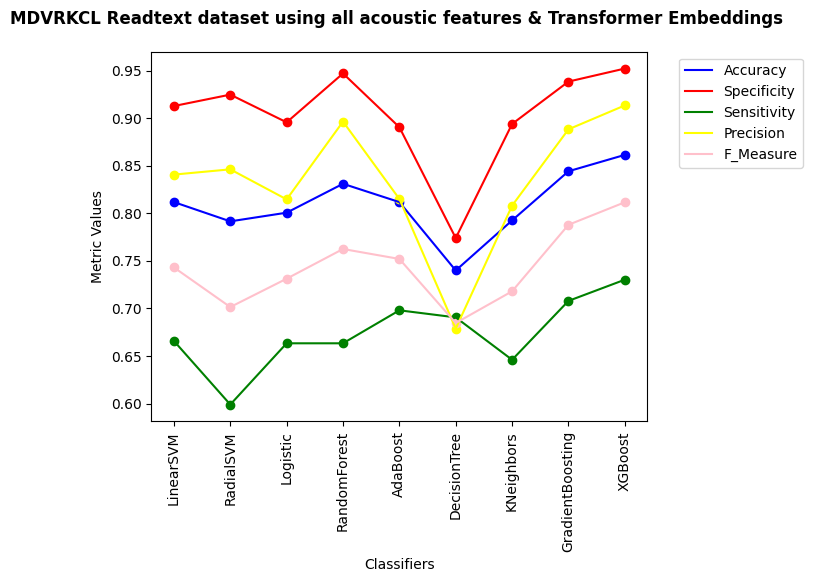

In [99]:
plt.title("MDVRKCL Readtext dataset using all acoustic features & Transformer Embeddings ",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")
plt.xticks(rotation="vertical")
plt.plot(score1['Classifier'], score1['Accuracy'], color='blue', label='Accuracy')
plt.plot(score1['Classifier'], score1['Specificity'], color='red', label='Specificity')
plt.plot(score1['Classifier'], score1['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score1['Classifier'], score1['Precision'], color='yellow', label='Precision')
plt.plot(score1['Classifier'], score1['F Measure'] , color ='pink' , label = 'F_Measure')
plt.scatter(score1['Classifier'], score1['Accuracy'], color='blue')
plt.scatter(score1['Classifier'], score1['Specificity'], color='red')
plt.scatter(score1['Classifier'], score1['Sensitivity'], color='green')
plt.scatter(score1['Classifier'], score1['Precision'], color='yellow')
plt.scatter(score1['Classifier'], score1['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [92]:
# Checking the evaluation metrices while considering all the acoustic features & MFCC  selected using genetic algorithm for MDVRKCL Readtext dataset
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(dfe)
le = LabelEncoder()
le.fit(label_pd)
label = le.transform(label_pd)

score2 = Evaluate(X_imputed,label)
score2_sorted = score2.sort_values(by="Accuracy", ascending=False)


In [93]:
score2_sorted.reset_index(drop=True, inplace=True)
score2_sorted

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,XGBoost,0.858300,0.943493,0.735149,0.900000,0.809264
1,GradientBoosting,0.843117,0.933219,0.712871,0.880734,0.787962
2,LinearSVM,0.814777,0.914384,0.670792,0.844237,0.747586
3,AdaBoost,0.811741,0.890411,0.698020,0.815029,0.752000
4,RandomForest,0.810729,0.943493,0.618812,0.883392,0.727802
5,Logistic,0.806680,0.893836,0.680693,0.816024,0.742240
6,KNeighbors,0.795547,0.897260,0.648515,0.813665,0.721763
7,RadialSVM,0.789474,0.924658,0.594059,0.845070,0.697674
8,DecisionTree,0.738866,0.775685,0.685644,0.678922,0.682266


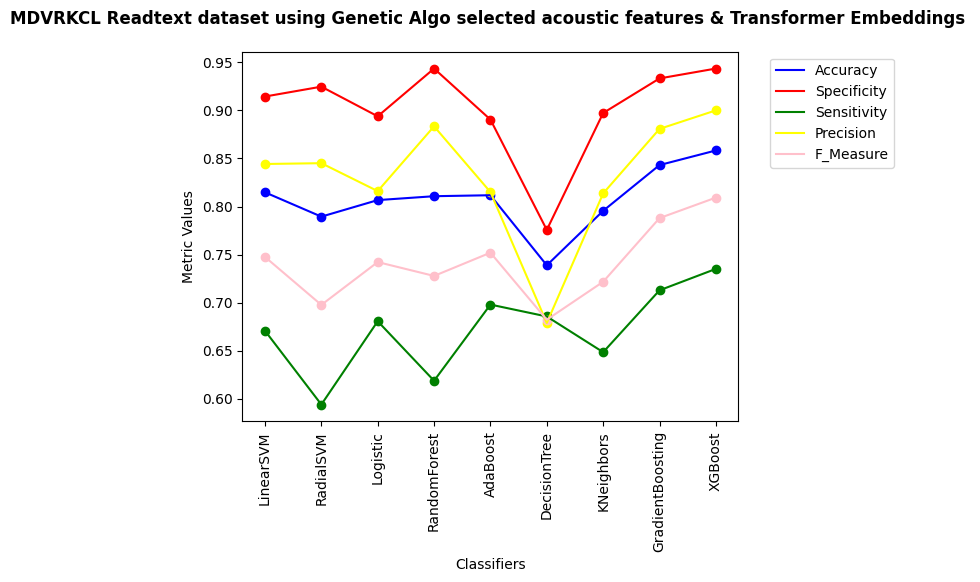

In [100]:
plt.title("MDVRKCL Readtext dataset using Genetic Algo selected acoustic features & Transformer Embeddings ",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")

plt.xticks(rotation="vertical")
plt.plot(score2['Classifier'], score2['Accuracy'], color='blue', label='Accuracy')
plt.plot(score2['Classifier'], score2['Specificity'], color='red', label='Specificity')
plt.plot(score2['Classifier'], score2['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score2['Classifier'], score2['Precision'], color='yellow', label='Precision')
plt.plot(score2['Classifier'], score2['F Measure'] , color ='pink' , label = 'F_Measure')

plt.scatter(score2['Classifier'], score2['Accuracy'], color='blue')
plt.scatter(score2['Classifier'], score2['Specificity'], color='red')
plt.scatter(score2['Classifier'], score2['Sensitivity'], color='green')
plt.scatter(score2['Classifier'], score2['Precision'], color='yellow')
plt.scatter(score2['Classifier'], score2['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [95]:
# Checking the evaluation metrices while considering all the acoustic features for MDVRKCL Spontaneous dataset

imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(dde1)
le = LabelEncoder()
le.fit(label_pd1)
label = le.transform(label_pd1)
score4 = Evaluate(X_imputed,label)
score4_sorted = score4.sort_values(by="Accuracy", ascending=False)
score4_sorted.reset_index(drop=True, inplace=True)
score4_sorted

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,XGBoost,0.825991,0.893145,0.745146,0.852778,0.795337
1,GradientBoosting,0.802863,0.891129,0.696602,0.841642,0.762284
2,LinearSVM,0.790749,0.889113,0.672330,0.834337,0.744624
3,Logistic,0.769824,0.842742,0.682039,0.782730,0.728923
4,RandomForest,0.766520,0.864919,0.648058,0.799401,0.715818
5,RadialSVM,0.747797,0.895161,0.570388,0.818815,0.672389
6,AdaBoost,0.745595,0.812500,0.665049,0.746594,0.703466
7,KNeighbors,0.742291,0.818548,0.650485,0.748603,0.696104
8,DecisionTree,0.701542,0.741935,0.652913,0.677582,0.665019


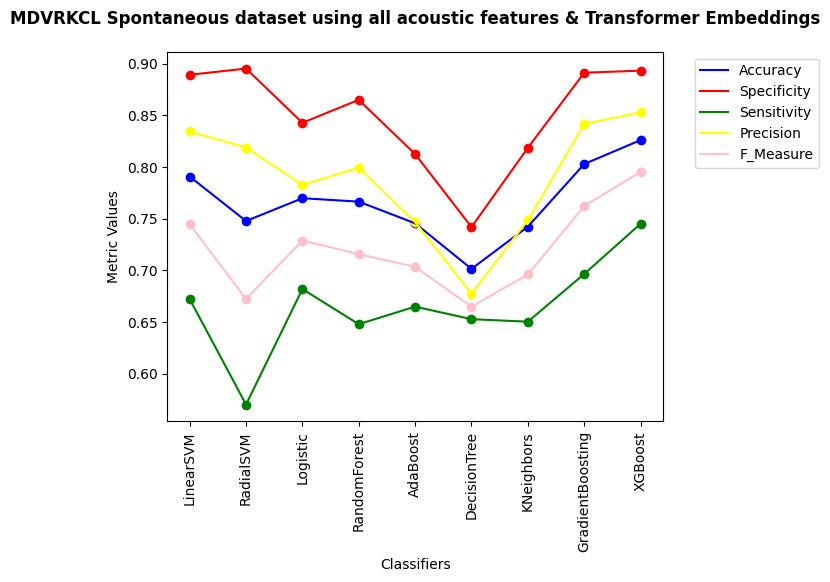

In [96]:
plt.title("MDVRKCL Spontaneous dataset using all acoustic features & Transformer Embeddings",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")
plt.xticks(rotation="vertical")
plt.plot(score4['Classifier'], score4['Accuracy'], color='blue', label='Accuracy')
plt.plot(score4['Classifier'], score4['Specificity'], color='red', label='Specificity')
plt.plot(score4['Classifier'], score4['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score4['Classifier'], score4['Precision'], color='yellow', label='Precision')
plt.plot(score4['Classifier'], score4['F Measure'] , color ='pink' , label = 'F_Measure')
plt.scatter(score4['Classifier'], score4['Accuracy'], color='blue')
plt.scatter(score4['Classifier'], score4['Specificity'], color='red')
plt.scatter(score4['Classifier'], score4['Sensitivity'], color='green')
plt.scatter(score4['Classifier'], score4['Precision'], color='yellow')
plt.scatter(score4['Classifier'], score4['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [97]:
# Checking the evaluation metrices while considering all the acoustic features selected using genetic algorithm for MDVRKCL Spontaneous dataset
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(dfe1)
le = LabelEncoder()
le.fit(label_pd1)
label = le.transform(label_pd1)
score5 = Evaluate(X_imputed,label)
score5_sorted = score5.sort_values(by="Accuracy", ascending=False)
score5_sorted.reset_index(drop=True, inplace=True)
score5_sorted

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,XGBoost,0.801762,0.879032,0.708738,0.829545,0.764398
1,GradientBoosting,0.796256,0.881048,0.694175,0.828986,0.755614
2,LinearSVM,0.762115,0.832661,0.677184,0.770718,0.720930
3,Logistic,0.757709,0.820565,0.682039,0.759459,0.718670
4,RandomForest,0.757709,0.866935,0.626214,0.796296,0.701087
5,AdaBoost,0.743392,0.814516,0.657767,0.746556,0.699355
6,RadialSVM,0.740088,0.895161,0.553398,0.814286,0.658960
7,KNeighbors,0.733480,0.820565,0.628641,0.744253,0.681579
8,DecisionTree,0.703744,0.741935,0.657767,0.679198,0.668311


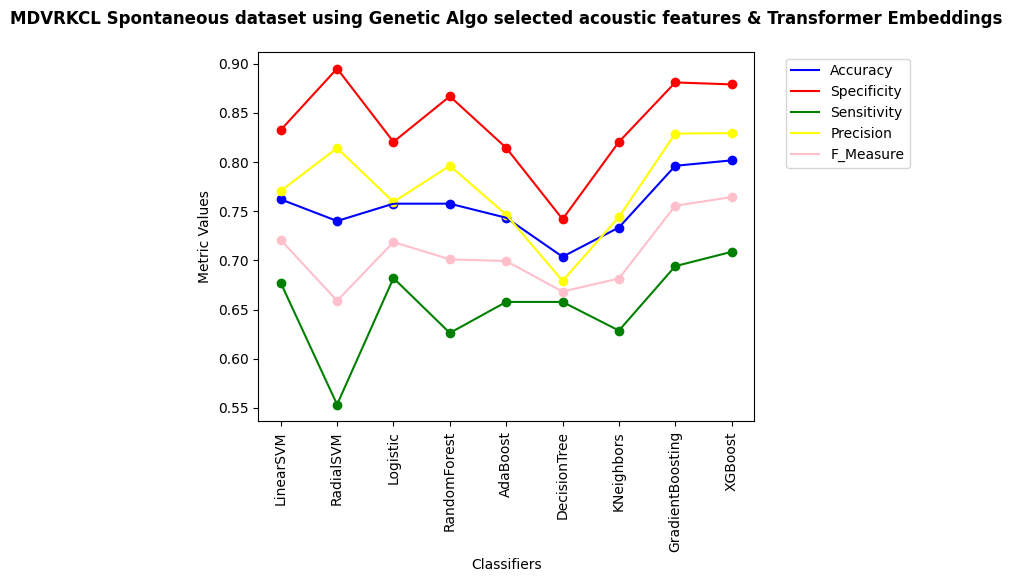

In [98]:
plt.title("MDVRKCL Spontaneous dataset using Genetic Algo selected acoustic features & Transformer Embeddings",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")
plt.xticks(rotation="vertical")
plt.plot(score5['Classifier'], score5['Accuracy'], color='blue', label='Accuracy')
plt.plot(score5['Classifier'], score5['Specificity'], color='red', label='Specificity')
plt.plot(score5['Classifier'], score5['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score5['Classifier'], score5['Precision'], color='yellow', label='Precision')
plt.plot(score5['Classifier'], score5['F Measure'] , color ='pink' , label = 'F_Measure')
plt.scatter(score5['Classifier'], score5['Accuracy'], color='blue')
plt.scatter(score5['Classifier'], score5['Specificity'], color='red')
plt.scatter(score5['Classifier'], score5['Sensitivity'], color='green')
plt.scatter(score5['Classifier'], score5['Precision'], color='yellow')
plt.scatter(score5['Classifier'], score5['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
